# W261 Final Project

##### W261_SP22_FINAL_PROJECT_TEAM28

#### MIDS W261: Machine Learning at Scale | UC Berkeley School of Information | Spring 2022

#### Team 28: Aditya Bajaj, Gerrit Lensink, Ruby Han, Tsun Tsai

# Table of Contents

This report is structured in six sections, outlining the flow of question formulation, logic, pipeline, and modeling efforts. 

First, we defined our business objective, key stakeholders, and business relevance as we **formulated the question**. Second, we focused on familiarizing ourselves with the data through **EDA**. This helped us identify key issues with the data we would have to solve in order to build an effective model. Next, we applied learnings from EDA to **transform and engineer new features** in our data preparation/join pipeline. Following data preparation and cleansing, we **explored algorithms** such as logistic regression, random forest, and gradient boosted trees as we tried to increase our prediction ability. Then, we studied and implemented a **custom MapReduce algorithm**, and drew **conclusions** from our model iterations. Finally, we provided an overview of **course concepts** leveraged throughout our pipeline and modeling efforts. 

I. Question Formulation

II. EDA & Discussion of Challenges

III. Feature Engineering & Pre-Processing

IV. Algorithm Exploration

V. Algorithm Implementation

VI. Conclusions

VII. Application of Course Concepts

Appendix

# I. Question Formulation

> **Prompt:** *You should refine the question formulation based on the general task description you’ve been given, ie, predicting flight delays. This should include some discussion of why this is an important task from a business perspective, who the stakeholders are, etc.. Some literature review will be helpful to figure out how this problem is being solved now, and the State Of The Art (SOTA) in this domain. Introduce the goal of your analysis. What questions will you seek to answer, why do people perform this kind of analysis on this kind of data? Preview what level of performance your model would need to achieve to be practically useful. Discuss evaluation metrics.*

## Business Relevance
> Describe motivation, clearly articulate question, takes limitations of data/algorithm into account

Flight delays are an incredibly costly consequence in the airline industry - affecting airlines with lost revenue and lost demand, as well as costing passengers time and money. The FAA estimates that in 2019, flight delays caused losses of roughly 33 billion dollars [1], in which airlines absorb 25% of the overall direct losses, and passengers receive over 50% of the losses. These delays cause direct impacts, such as lost revenue for airlines or wasted time for customers, as well as indirect impacts such as built-in planning buffers. These buffers then result in lower plane and resource utilization, leading to increased ticket prices and other secondary costs, such as lost "good will" and competitiveness with other airlines. Flight delays are commonly caused by, but are not limited to, issues related to a particular carrier, weather, security, or restrictions set by the National Air Services [3].

As costs rise, airlines are increasingly motivated to predict delays as soon as possible to save losses both for their business and their customers. Current state of the art models, such as neural nets are able to predict with precison in the low to high 90%s [2]

The purpose of this report is to provide a model that predicts flight delays, specifically tailored for use by airline companies. A flight delay is defined as any departure that occurs 15 minutes or greater than the scheduled departure time.

## The Data
> Dataset and contents are clearly introduced

All models trained, validated and tested over the course of this report leveraged three separate datasets, spanning years 2015 to 2019. The basis of all modeling was a set of domestic United States flights as collected by the US Department of Transportation [3]. In attempt to increase the power of the model, we also included weather data from the NOAA [4], with metrics across thousands of weather stations. Finally, a stations dataset was leveraged to map each airport to it's closest weather station [5]. Specifics on joining each dataset are addressed in Section III. Further discussion of data issues and exploration are included in Section II. 

### Airline Data

The airline table provided records for nearly 32 million scheduled flights spanning 2015 to 2019. This dataset included 109 unique features, with important information including scheduled flight time and date, origin and destination airport, and identifiers such as flight number, which were instrumental in feature engineering. Flight observations were either classified as on time (`DEP_DEL15 = 0`), delayed (`DEP_DEL15 = 1`), or cancelled (`DEP_DEL15 = NULL`). 

### Weather Data

Weather data consisted of over 630 million weather observations, with 177 different features. Roughly one third of these features were direct weather measurements such as temperature and wind speed, while the remainder were metedata that provided information on the quality of measurement, or instrument the observations were captured with. This dataset included many different weather stations per city, as well as granular observations with respect to time, attributing to the large size of the data. We focused on choosing and deriving features from this dataset that were believed to be highly correlated with delayed flight outcomes. 

### Station Data

The stations dataset was provided to link NOAA weather stations to the airports included in the DOT airlines dataset. This helper table consisted of 2,237 unique airport (ICAO) codes across the united states. The table is a flat representation of a square matrix, including a distance metric from each unique airport to all others, represented as 'neighbor'. The flat representation of this matrix is 5 million observations, or \\(2237^2\\). This table is immediately reduced down to each unique airport and it's closest weather station, which allows a link between `Airline` and `Weather`.

## Evaluation Metrics
> What metric do we use to know if we have a good model?

Our model predicts whether a flight is expected to be delayed by more than 15 minutes, as late as two hours before the scheduled departure time. Specifically, our target variable is `DEP_DEL15`, where '1' represents a flight delay of 15 minutes or greater, and 0 represents an on-time departure (or an 'insignificant' delay of less than 15 minutes).

As the focus of our model is to reduce costs specifically for the airline, we focus primarily on minimizing the rate at which false positives are predicted. Within this modeling framework, airline costs are minimized by reducing the rate at which a flight is predicted to be delayed, when it will not actually have to be delayed. False positives trigger reactions such as pushed or cancelled flights and customer cancelations, as well as costly actions by airlines to attempt to return to schedule and retain customers, such as incentives to take the next flight. 

Because of the high cost of false positives, we focus primarily on minimizing the rate at which false positives are predicted, which is represented formally as a measure of "Precision" [\\( Precision = \frac {FP}{FP + TP} \\), where \\(FP\\) = False Positive and \\(TP \\) = True Positive]. Precision is heavily influenced by minimizing False Positives, represented by the yellow box in the confusion matrix below (Figure 1). Models focused entirely on precison maximzation, however, would not be optimal for the purpose of our business context, as our central goal is effective prediction of delay. Therefore, recall [\\( Recall = \frac {TP}{TP + FN} \\), where \\(FN\\) = False Negative] must also be considered, as it measures the ability to predict a delay when it will actually occur. The **final metric we use to evaluate our models was F0.5**, which provides a weighted balance between precision and recall, with an emphasis on improving precision. The final result is a minimzation of false positives, weighted higher than the minimzation of false negatives [6].

Initial models performed in the low 25%s, and our final model apporoached an F0.5 score of 56%. 

Ideally, our model would achieve 75% F0.5 or greater to be practically useful. A discussion on our inability to perform at such rates is included in Appendix B: Gap Analysis.

**Figure 1: Example of Confusion Matrix**

![fig1](https://raw.githubusercontent.com/ruby-han/W261/main/images/fig1.png)

# II. EDA & Discussion of Challenges

> **Prompt:** *Determine a handful of relevant EDA tasks that will help you make decisions about how you implement the algorithm to be scalable. Discuss any challenges that you anticipate based on the EDA you perform.*~

> Introduction to EDA, why did we choose the below EDA tasks, **how do they relate to the potential challenges** in our data/alrogrithm

Throughout EDA, we identified a number of concerns that needed to be addressed throughout the course of our pipeline and modeling. These included class imbalance, missing values, and collinearity. Finally, we explored some initial data for a **novel** feature based on domestic PageRank. Each of the below EDA tasks are included within specific notebooks [A].

### EDA Task 1: Class Imbalance

Before modeling, we explored the proportion of observations across our predicted class `DEP_DEL15`. This proportionality, or "class im/balance" is crucial in training models that are able to effectively predict actual outcomes based on past data [A]. 

From our initial sampling, we observed that \~76% of all observations were classified as on-time, 22% as delayed, and the remaining 2% as cancelled (Figure 2). Our primary hurdle in achieving high levels of prediction ability was centered around class imbalance.  Without treatment, this led to prediction of the majority class - which resulted in roughly 80% accuracy (\~80% of observations are the majority class), but incredibly low F scores as precision and recall were essentially zero. 

In an attempt to reduce the effects of class imbalance and improve model predictions, we employed methods of undersampling and oversampling. Further discussion of these methods is found in Section III.

**Figure 2: Class Imbalance**

![fig2](https://raw.githubusercontent.com/ruby-han/W261/main/images/fig2.png)

### EDA Task 2: Null Values

Another issue we faced that required treatment was the amount of features across both `airlines` and `weather` that contained a majority of null observations. Many models such as logistic regression are not set to naturally handle null values, so we had to choose between three options when encountering null data: (1) remove features (2) remove observations (3) impute null values. Each of these options had benefits and costs. For example, simply dropping null features would be the simplest, but would leave us with very few obvservations, and these null values are likely not randomly distributed. Removal of an entire feature is relatively simple, but we might be excluding interesting information for other non-null observations. Finally, imputation is a common practice for filling null values - but this clouds prediction as we are filling missing observations with some sort of aggregate over a previously occuring window. 

Figure 3 below [A] shows each of our features plotted against the % of null values contained within that feature. The majority of our features have 70%+ null values, many in the range of 90%+. In these cases, imputation would be highly unreliable for two reasons:

1. There may not be enough data in the 'look-back' horizon to fill the current observation.
2. So much of the data is missing, that filling nulls with an aggregate would not provide much meaningful information for the model. 

Because of these two concerns, features with null value representation of 70%+ were discarded. The remaining set of features were imputed, which is discussed further in Section III. 

Null values pose a large threat to model validity and also influence our pipeline architecture, so our strategy for null value treatment is very important from both a modeling results and pipeline run time standpoint.

**Figure 3: Null Data**

![fig3](https://raw.githubusercontent.com/ruby-han/W261/main/images/fig3.png)

### EDA Task 3: Collinearity Between Predictors, and Correlation between predictors and outcome of interest

One of our final large challenges was narrowing down the 175+ features. Following removal of null-heavy features, we had two objectives when choosing our remaining features: 
1. Ensure features are not collinear - collinear features lead to less reliable predictions, and reduced model power [7]
2. Choose features with the highest information contribution to our predictor

Figure 4 represents a correlation matrix, which helps identify possible sources of collinearity. For example, scheduled time in flight (`CRS_ELAPSED_TIME`) and `DISTANCE` are heavily correlated, with a correlation coefficient of .99. This means it is not necessary to include both of these features - instead we can reduce our feature list, while retaining roughly the same amount of information, by choosing one or the other. From matrices like these, we selected features with lower correlation coefficients. 

After reducing the set of features to non-collinear predictors, we can then measure the correlation between our outcome variable with features we believe will be most successful in prediction. For example in Figure 5, we can see that flights with previous delayed arrivals are strong predictors of delayed departures. This helps inform future feature engineering, where we create time-based features to track prior flight delays, given the two hour frozen window we are constrained to.

**Figure 4: Collinearity Matrix**

![fig4](https://raw.githubusercontent.com/ruby-han/W261/main/images/fig4.png)

**Figure 5: Top Predictors**

![fig5](https://raw.githubusercontent.com/ruby-han/W261/main/images/fig5.png)

### EDA Task 4: PageRank
Finally, we explored more **novel approaches** to flight prediction. We hypothesized that "busier" airports may be heavily positively or negatively correlated with flight delays. We explored this busy-ness in two ways. First, with an "Airport stress" measure (further discussed in Section III), and second by leveraging the famous PageRank algorithm. 

In our application, PageRank measures the centrality of an airport throughout the network, highlighting airports that are central connectors within the overall flight grid in the United States. Figure 6 shows large bubbles for airports that are seen as nodes with high outlinks, which are recognizeable as common hubs in the United States. For Example Atlanta, Delta Airlines' HQ and large hub, is marked with the highest pagerank - meaning it is the most 'important' in our flight graph. We hypothesize that airports with higher PageRank will be related to higher departure delays.

Interestingly, we see airports we'd expect to be quite busy, such as JFK and SFO with lower-than-expected PageRank scores. This is due to the domestic nature of our dataset - as these hubs commonly service international routes, which are not represented in our PR calculation. Instead, we see nodes with geographic centrality (e.g. Denver, Dallas, Chicago, Atlanta) encompassing the largest share of PageRank as they are large connectors of both cross-country and regional flights. 

Further discussion of PageRank as a **Novel**/engineered feature is found in Section III, Stage E.

**Figure 6: Airport PageRank (2015-2019, US Domestic)**

![fig6](https://raw.githubusercontent.com/ruby-han/W261/main/images/fig6.png)

# III. Feature Engineering & Pre-Processing

> **Prompt:** *Apply relevant feature transformations, dimensionality reduction if needed, interaction terms, treatment of categorical variables, etc.. Justify your choices.*

## Pipeline
> all steps, with justification

Our pipeline is separated into seven different stages as shown in figure 7 below (A-G), with four main objectives: 
   
1. Prepare data for join
2. Transform features to address concerns identified in EDA
3. Create features to add power to model
4. Search across hyperparameters/models to find best model

Details on each stage of the pipeline follow Figure 7 below.

**Figure 7: Pipeline Schematic**

![fig7](https://raw.githubusercontent.com/ruby-han/W261/main/images/fig7.png)

### Stage A: Data Load

Initial data load was one of the first and simplest problems we encountered. We chose to heavily leverage parquet files for reading data (and saving checkpoints to blob). In general, parquet's column-wise format is more efficient both from a storage perspective as well as read speed compared to CSV or text format [8]. Once loaded from parquet, we converted tables to spark Dataframes which allowed for efficient usage of sparkSQL. All final data operations were applied to spark dataframes, with some EDA on smaller samples using pandas dataframes. Caching was another practice used to increase speed of operations. Throughout series of transformations, intermediate steps were cached (and evaluation forced) to keep operations as close to memory as possible. This was instrumental in achieving quick join times, discussed in Stage C. 

The `flights`, `station`, and `weather` data were all loaded separately within their respective `data_processing_` notebooks, where relevant transformations were applied. Stage B outlines each of these transformations in detail.

### Stage B: Transform I

**Feature Selection**

As discussed in Section II EDA Task 2, a large share of our features across both `flights` and `weather` tables were represented by 70% or higher null observations. These features were dropped entirely, as they did not contain sufficient surrounding information to impute data meaningfully. With such large representation of missing values, feature values would be overly represented by summary aggregations, such as average - removing unique information from observations. 

Remaining features were selected based on their hypothesized predictability relying on light domain knowledge from research and included codebooks. A full list of included base features is found in Appendix D, in addition to engineered features outlined in Stage E. Across modeling iterations, feature importance was ranked, and our engineered features retained top importance across the majority of models. An example of this is included in Figure 8, which suggests some information in the data was most helpful to our predictability by leveraging domain knowledge, and teasing out underlying patterns in the data.

**Figure 8: Feature Importance Example**

![fig8](https://raw.githubusercontent.com/ruby-han/W261/main/images/fig8.png)

Following feature selection, we prepared the data for join, transformed features, and treated missing values. 

**Preparation for join and data leakage considerations**

Each of the discussed operations for the below tables are contained across three notebooks [C].

`flights`

First, flight observation timestamps were converted to UTC. Each of the observations were reported in local time for each origin, so conversion to UTC allowed link to the `weather` table, which was already reported in UTC. Example code is included in Code Chunk 1 at the bottom of this section. 

Next, timestamps were converted to hourly, rather than hour:minute. For each flight observation, there was no guarantee that there would be a weather observation available for each exact scheduled flight time. Therefore, to ensure the minimum amount of data was linked to null weather observations, we removed minutes from each flight observation, effectively 'rounding down' each flight observation to the nearest hour. 

Following conversoin to hourly UTC timestamps, we needed to create a time-based key that would allow us to connect each flight observation with weather data, accounting for a two-hour freeze in information before flight departure. To do this, we created a new 'lagged' time variable, initially equivalent to the flights **UTC scheduled departure time minus two hours**. After creating this lagged key, we needed to ensure that our conversion to hourly timestamp would not lead to data leakage. As shown in **Case 1** in Figure 9 below, rounding down both airline and weather data led to possible data leakage when implementing a two-hour lag. For example, if flight time is 1:01 PM, our hourly conversion would 'round down' to 1:00 PM observation. Lagging by 2 hours would lead us to join on weather timestamps of 11:00 AM. This creates issues, however, as 11:00 AM weather timestamps which were also rounded down (outlined further below in `weather`) can contain weather observations from 11:00 to 11:59. In the worst case scenario - where 11:59 is the only timestamp available over the 11:00 AM weather block - this would lead to data leakage, as we would only be lagging by 1 hr 2 mins when comparing **Actual** Flight and weather observations times. 

Because of this data leakage - we were forced to re-evaluate our strategy, and instead chose to lag by three hours. As shown in Figure 9 **case 2**, this ensures that in the worst case scenario we are now preventing weather observations *within* two hours. This does not come without trade-offs, however, as we see a maximum of three hours of lag when the weather time is closest to the next rounded time-block (10:59 vs. 11:00). This tradeoff is less than ideal as in some cases we lose the ability to leverage the most recent weather observations. The tradeoff is necessary, however, in order to ensure data leakage does not occur. Final implementation of our lagged variable required an **hourly lag of 3 hours**.

**Figure 9: Data Leakage Strategy for Timestamp Lag and Join**

![fig9](https://raw.githubusercontent.com/ruby-han/W261/main/images/fig9.png)

`station`

In order to join `station` to `weather`, we required a key that would allow a link between the two datasets. `station` provided each domestic airport (ICAO) code, mapped to every weather station, including the distance between each airport and weather station. Our first step was to reduce the 5-million-observation list to the roughly two thousand unique airport codes, and their nearest weather station. This then provided a mapping of each airport and the nearest weather station by which we could pull weather metrics. Distillation of this table is found in Code Chunk 2 at the bottom of this section. 

`weather`

Much like the `airlines` data, weather observations also needed to be reduced to hourly observations for join. This requried some additional processing than was applied to flight data, since at a given station, each hour can contain many weather observations. To account for this, we reduced minute weather observations to hourly in two steps: 
1. Take the earliest observation for each hourly time block for each station
    
    a. For example, if measures were observed at 11:01, 11:30, and 11:59, the 11:01 observation would be retained and the remaining observations excluded. This was an intentional decision to reduce data leakage during join. 

2. Drop the minutes from the chosen weather observation, effectively rounding down to the nearest hour.

Following weather timestamp aggregation, we encountered three additional issues that required treatment before join. First, many of the weather observations were reported as a concatenated string of both weather data, as well as metadata. Discussion of transformations required here is found below in **Feature transformation**. 

Second, following split of composite features, we removed data coded as 'erroneous', discussed in **Missing Value Treatment** below. 

Finally, the data contained many missing values, which were treated as discussed in **Missing Value Treatment** below. 

**Feature Transformation**

`airlines`

As discussed above, flight observations were converted to UTC and lagged by 3 hours. No additional feature transformations were applied at this stage. 

`station`

No feature transformation necessary.

`weather`

Within the 177 original columns of the `weather` table, six features were composite, including `WND`, `CIG`, `VIS`, `TMP`, `DEW`, and `SLP`. Each of these features were split into relevant columns rather than retaining the concatenated values (Code Chunk 3, below). For example, the `WND` variable was a composite feature consisting of 5 unique sub-features: Speed, type, angle, and two quality metadata. 

After separation of concatenated features, each of these features had different 'codes' for missing data, rather than 'NULL'. In order to leverage built-in fuctions such `.isNull()`, missing observations across each variable were replaced with 'null' for each missing data code included in the codebook. 

Further feature transformation for our **joined dataset**, such as standardization and one-hot encoding, was applied following join, discussed in Stage D, Transform II. 

**Missing Value Treatment**

As discussed in Feature Selection, features with over-represented proportions of nulls were dropped, leaving features with 'manageable' proportions of nulls in each of the below tables. Even though these features did not contain a majority of null values, each missing values still required treatment, as many models such as logistic regression are not built to account for nulls. 

`airlines`

A small proportion of overall flight data contained null schedule time observations. With minimal opportunity to impute these observations, these rows were dropped from the dataset. 

Null values were not encountered across the remaining included features. 

In addition to checks for null values - we also focused on identification of duplicate data. This was accomplished by creating a new unique_id column, which is a concatenation of `FL_DATE`, `TAIL_NUM`, `ORIGIN`, and `CRS_DEP_TIME`. Duplicates identified are commonly related to cancelled flights that are later replaced by flights to a different destination, with same `FL_DATE`, `TAIL_NUM`, and `ORIGIN`. Cancelled flights were dropped, and replacement flights were retained. 

`station`

Null values were not encountered across station data. 

`weather`

Weather data provided the largest proportion of missing values across each feature. Dropping these observations would have led to large data loss - leaving many flight observations without weather data. Rather than dropping null observations, we focused on imputing weather data by leveraging a 7-day average look-back. For each missing weather observation, we replaced null values with average of that measure over the prior 7 days. This approach is not without flaw - as each imputation still produces data loss - as aggregate information is not necessarily representative of each hour in a day or day in a week. However, given the tradeoff of dropping entire rows, this strategy was preferred. Examples of this imputation are included in Code Chunk 5 at the bottom of this section.

### Stage C: Join

Following missing value treatment and transformations, we were able to start joining together `weather` and `airlines` data to create our main dataset. The workflow of joins is as follows (also exemplified in Figure 10): 

##### Mapping ICAO code to closest weather station

As mentioned in Stage B, `station` data was grouped by `neighbor_code` (`IATA`), reducing the list of stations down to the closest station to each `IATA`, given the provided distance metric. This yielded a two-column mapping table with a unique set of `ICAO` and it's closest weather `station_id`. This new table is referred to as `station_mapping`

Flight data was then augmented by joining weather data, using the `stations` table as a mapper between airports/cities in `airlines` and `weather`. Before left-joining `station` on `airlines`, three-letter IATA codes in flight data were mapped to 4-letter ICAO codes. (Code Chunk 2)

##### Joining Airline and Station Data (Join 1)

`station_mapping` is left joined on `airlines` by `ICAO`. No explicit distance calculations were necessary, as `station_mapping` provided the closest weather station for each airport. 

##### Joining Weather data on Airline Data with Station Mappings (Join 2)

Once each flight observation was mapped to a it's relevant `station_id`, hourly weather data was left-joined on hourly airline data, keying on `station_id` and `CRS_DEP_TIME_UTC`. During join, all weather observations were lagged by 3 hours to eliminate leakage on hourly-rounded data. Further discussion of transformations required for hourly airline and weather data are found below in Section II.

Code for Join 1 and 2 is included in Code Chunk 6 at the bottom of this section. 

Before Joining on the full dataset for Phase III, the student group tested joins numerous times on subsets of the data. 

#### Pipeline Performance

Given the Phase III Infrastructure and Scaling (80GB 20 cores), we completed our final join within 5 minutes. This join time was supported by heavy caching and checkpointing, which each took 5-10 minutes per checkpoint on average. Including total checkpoint time, the entire Join pipeline is estimated to have run within 1 hour.

**Figure 10: Joins**

![fig10](https://raw.githubusercontent.com/ruby-han/W261/main/images/fig10.png)

### Stage D: Transform II

After joining data we applied one final set of transformations to the full dataset, rather than to each distinct dataset before join. These transformations included One-hot encoding, vector-assembly of all features, scaling, and under-sampling. Each of these transformations are included in our final code notebook [F].

#### One-Hot Encoding

One-hot encoding is employed to deal with non-numerical features. This technique is important as it allows our machine learning model to make best use of categorical information. Current implementation includes one-hot encoding of all categorical variables, which expands our feature list greatly. Each categorical feature is split into as many columns as exist unique values, and coded with a 1 or 0 where that value is present. This greatly expands the number of features, which motivates some sort of reduction, like a vector assembler. 

#### Vector-assembly

Following feature transformation and engineering, the final set of features was ran through a vectorizer to simplify train and reduce computation complexity. The set of features is represented as a sparse vector, rather than a full column representation of the feature set.

#### Scaling

Features with varying scales reduce a models predictability [9]. For this reason, we scaled all of our continuous features using the built-in `RobustScaler()` package. Unlike other scalers that center data around the mean, RobustScaler centers the data around the median. This allows for lesser influence of outliers, which are known to heavily influence the mean during standardization. 

#### Under-sampling

Under-sampling was employed to address extreme class imbalance by reducing the amount of observations in the over-represented class. Our implementation results in a reduction of roughly 20% of all non-cancelled flights. This transformation was purposefully implemented only to the train set during cross-validaton (Discussed in Stage F), rather than to the entire dataset. Implementation of undersampling to test data results in inflation to validation metrics, and must be avoided.

### Stage E: Feature Engineering

> Clearly explain each new column

Following data processing and cleaning we created **12** new features as showcased below. Each of these features were created with the intention of adding or augmenting data that was underlying in our data. These features increased our prediction metrics, and were instrumental in achieving higher modeling statistics. Code for each of the features created is included in Code Chunk 7. 

#### Flight Delay Propagation

We explored the hypothesis that delays propagate through both time and space. For example, a flight departing or arriving late will cause delays for its next scheduled departure (time propagation). In addition, a delay in flights could cause airport operational stress and result in other flight delays (space propagation).

##### Data Leakage Prevention Strategy

We took great care to prevent data leaks in our engineered features. The below features were offset by a row over a window partitioned by `TAIL_NUM` and ordered by `CRS_ARR_TIME_UTC`. Time of prediction was set two hours prior to `CRS_DEP_TIME_UTC`. 

`PRIOR_ARR_DEL15`: 
- 0 for prior arrival that is on-time or at least 15 minutes before time of prediction
- 1 for prior arrival if more than 15 minutes of delay
- -1 for prior arrival past time of prediction (2 hours prior next scheduled departure time)

`PRIOR_DEP_DEL15`: 
- 0 for prior departure that is on-time or at least 15 minutes before time of prediction
- 1 for prior departure if more than 15 minutes of delay
- -1 for prior departure within 15 minutes of time of prediction
  - Departure delay information will not be available
  - Highly unlikely scenario
  
#### Airport Stress Distribution

We explored the hypothesis that airport operational stress at origin and destination could cause flight delays through space propagation.

##### Data Leakage Prevention Strategy

The below features were measured 1, 3, 5 and 22 hours prior to time of prediction (two hours prior to `CRS_DEP_TIME`).

`PROB_DEP_DEL15_ORIGIN_PRIOR_1H`:
- 15-minute delay probability over past hour from time of prediction at origin airport

`PROB_DEP_DEL15_ORIGIN_PRIOR_3H`:
- 15-minute delay probability over 3 hours from time of prediction at origin airport

`PROB_DEP_DEL15_ORIGIN_PRIOR_5H`:
- 15-minute delay probability over 5 hours from time of prediction at origin airport

`PROB_DEP_DEL15_ORIGIN_PRIOR_22H`:
- 15-minute delay probability over 22 hours from time of prediction at origin airport

`PROB_DEP_DEL15_DEST_PRIOR_1H`:
- 15-minute delay probability over past hour from time of prediction at destination airport

`PROB_DEP_DEL15_DEST_PRIOR_3H`:
- 15-minute delay probability over 3 hours from time of prediction at destination airport

`PROB_DEP_DEL15_DEST_PRIOR_5H`:
- 15-minute delay probability over 5 hours from time of prediction at destination airport

`PROB_DEP_DEL15_DEST_PRIOR_22H`:
- 15-minute delay probability over 22 hours from time of prediction at destination airport

#### Actual Pilot Input

We managed to consult with an actual pilot at the very last minute in terms of weather parameters that may affect take-off. We gathered that the absolute difference between the dew point temperature and ambient temperature provides meaningful take-off indicators compared to dew point temperatures and ambient temperatures on their own individually.

`ORIGIN_WEATHER_AIR_DEW_POINT_TEMP_DIFFERENCE`:
- Absolute difference between `ORIGIN_WEATHER_TMP_AIR_TEMP-AVG` and `ORIGIN_WEATHER_DEW_POINT_TEMP-AVG`


#### Pagerank

As introduced in Section II EDA Task 4 - PageRank, our group chose to calculate and implement PageRank as a **novel aspect** of our modeling. We hypothesized that airports with higher degrees of centrality would be systematically different in terms of frequency of delay than airports with lower centrality. 

`pagerank`:
- Numeric measure of an airport's centrality with a graph

##### Explanation of Novel Approach

Interestingly, we can model many real-life problems in a **graph framework**, which is a collection of 'nodes' or actors, and 'edges' that connect them, which represent some sort of relationship or action. The United States airport network is one such example that we can model as a graph. Each airport is considered a node, and each edge is a representation of the flight path between an origin airport, and a destination airport. 

This graphical framework opens up many possibilities to apply algorithms that will help us better understand a network and the interactions of airports within it. One measure of these interactions is centrality - which aims to define how 'central' one node is amongst all other nodes. There are numerous measures of centrality like betweenness and degree centrality, but one of particular interest is PageRank, which is an innovative measure of a node's importance within a network. Within the context of the US flight network - this measure of importance helps us understand which airports have heavy pass-through traffic, that influence or reach many of the other airports throughout a graph. We expect that if problems exist at an airport with high PageRank (importance), they might trickle throughout the network at a higher rate than if they occured at a lower PR airport. 

PageRank was developed by scholars at google, and  is the backbone of Google's search engine. In Google's early days it was the primary system to determine the most important web pages during a search query. Since it's inception, Google has added in many other intelligent algorithms to help return most relevant web resuts, but it still remains an effective algorithm in terms of determining 'importance' within a network [10].

The backbone of the classical PageRank algorithm is a Markov Chain, which is a mathematical representation of a random walk across a graph. Plainly, within the context of our flight network - a markov chain helps us model a a Plane that is randomly placed at an airport, flying at infinity choosing it's next destination randomly. Through this algorithm, we learn the probabilities of moving to each different airport from a given point, which is represented by a structure called the transition matrix. When the random walk (or flight occurs), a transition matrix is learned based on connectivity of each node to each other node. When a network is flown ad infinitum, this transition matrix eventually converges to a steady state set of probabilities, that help us rank centrality. 

To ensure this process will work however, we must ensure our graph structure satisfies a few requirements, which make it *well-behaved*. To consider a graph well-behaved it must be: 
1. Irreducible: each airport has the ability to be connected to every other airport 
2. Aperiodic: no sinks or explcit paths exist that ensure a surfer (plane) will end up at the same place continually

The algorithm itself can ensure these two criteria are met by applying two adjustments to every graph. First, we can treat sink nodes and spread probability of leaving this particular node across all others - this is referred to as stochasticity. Second, 'teleportation' is added, which allows a random jump to occur with a certain probability at any time, allowing a jump to any random node (airport) in the network. 

In summary, PageRank allows us to calculate the importance of a set of airports within the US flight network, and regress on them to understand how importance might affect the frequency of flight delays.

In [0]:
##### CODE CHUNK 1: TIMESTAMP CONVERSION #####

#### FULL CODE INCLUDED HERE: https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/2866290024316332/command/2866290024316333

# rename headers
airport_coord = airport_coord.rename(columns=
                                       {0: 'AIRPORT_ID',
                                        1: 'AIRPORT_NAME',
                                        2: 'AIRPORT_CITY',
                                        3: 'AIRPORT_COUNTRY',
                                        4: 'IATA',
                                        5: 'ICAO',
                                        6: 'AIRPORT_LAT',
                                        7: 'AIRPORT_LONG',
                                        8: 'AIRPORT_ALT',
                                        9: 'AIRPORT_UTC_OFFSET',
                                        10: 'AIRPORT_DST',
                                        11: 'AIRPORT_TIMEZONE',
                                        12: 'AIRPORT_TYPE',
                                        13: 'AIRPORT_DATASOURCE'})

# convert to spark df
airport_coord = spark.createDataFrame(airport_coord)

# join on airport_coord to airlines data based on origin
KEY_list = ['IATA', 'ICAO', 'AIRPORT_LAT', 'AIRPORT_LONG', 'AIRPORT_TIMEZONE', 'AIRPORT_UTC_OFFSET']
airport_coord_origin = main_data_df.join(airport_coord.select('IATA', f.col('IATA').alias('IATA_ORIGIN'),
                                                            'ICAO', f.col('ICAO').alias('ICAO_ORIGIN'),
                                                            'AIRPORT_LAT', f.col('AIRPORT_LAT').alias('AIRPORT_LAT_ORIGIN'),
                                                            'AIRPORT_LONG', f.col('AIRPORT_LONG').alias('AIRPORT_LONG_ORIGIN'),
                                                            'AIRPORT_TIMEZONE', f.col('AIRPORT_TIMEZONE').alias('AIRPORT_TIMEZONE_ORIGIN'),
                                                            'AIRPORT_UTC_OFFSET', f.col('AIRPORT_UTC_OFFSET').alias('AIRPORT_UTC_OFFSET_ORIGIN')),
                                                            airport_coord.IATA == main_data_df.ORIGIN).drop(*KEY_list)
flight_data = airport_coord_origin.join(airport_coord.select('IATA', f.col('IATA').alias('IATA_DEST'),
                                                             'ICAO', f.col('ICAO').alias('ICAO_DEST'),
                                                            'AIRPORT_LAT', f.col('AIRPORT_LAT').alias('AIRPORT_LAT_DEST'),
                                                            'AIRPORT_LONG', f.col('AIRPORT_LONG').alias('AIRPORT_LONG_DEST'),
                                                            'AIRPORT_TIMEZONE', f.col('AIRPORT_TIMEZONE').alias('AIRPORT_TIMEZONE_DEST'),
                                                            'AIRPORT_UTC_OFFSET', f.col('AIRPORT_UTC_OFFSET').alias('AIRPORT_UTC_OFFSET_DEST')),
                                                            airport_coord.IATA == main_data_df.DEST).drop(*KEY_list)

time_list = [flight_data.CRS_DEP_TIME, flight_data.DEP_TIME, flight_data.ARR_TIME, flight_data.CRS_ARR_TIME]
utc_time_list = ['CRS_DEP_TIME_UTC', 'DEP_TIME_UTC', 'ARR_TIME_UTC', 'CRS_ARR_TIME_UTC']

for time_col, utc_time_col in zip(time_list[:2], utc_time_list[:2]):
    flight_data = flight_data.withColumn(utc_time_col, 
                       f.to_timestamp(
                         f.concat(
                           f.col('FL_DATE'),
                           f.lpad(time_col, 4, '0')
                         ), format='yyyy-MM-ddHHmm'
                       ))\
            .withColumn(utc_time_col,
                       f.to_utc_timestamp(f.col(utc_time_col), 
                                          f.col('AIRPORT_TIMEZONE_ORIGIN'))
                       )

for time_col, utc_time_col in zip(time_list[-2:], utc_time_list[-2:]):
    flight_data = flight_data.withColumn(utc_time_col, 
                       f.to_timestamp(
                         f.concat(
                           f.col('FL_DATE'),
                           f.lpad(time_col, 4, '0')
                         ), format='yyyy-MM-ddHHmm'
                       ))\
            .withColumn(utc_time_col,
                       f.to_utc_timestamp(f.col(utc_time_col), 
                                          f.col('AIRPORT_TIMEZONE_DEST'))
                       )

In [0]:
##### Code Chunk 2: Weather station to Airport Mapping #####
#### FULL CODE INCLUDED HERE: https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/2866290024316534/command/2866290024316566

# Select Relevant Columns only
df_stations = df_stations.select(['neighbor_call', 'station_id', 'distance_to_neighbor']).orderBy(['neighbor_call','distance_to_neighbor'])

# For each ICAO (airport), find the closest weather station
station_to_ICAO = df_stations.withColumn('row_number', f.row_number()\
                                 .over(Window.partitionBy(f.col('neighbor_call'))\
                                 .orderBy(f.col('distance_to_neighbor').asc())))\
                                 .where(f.col('row_number') == 1)\
                                 .drop(f.col('row_number'))

# Rename some columns
ICAO_station_mapping = station_to_ICAO.withColumnRenamed('neighbor_call', 'ICAO')\
                                      .withColumnRenamed('station_id', 'WEATHER_STATION_ID')\
                                      .drop('distance_to_neighbor') # After inspection, can see the distance is 0 for all included stations - so weather station is on airport grounds

In [0]:
##### CODE CHUNK 3: TRANSFORMING CONCATENATED FEATURES TO UNIQUE FEATURES #####
####FULL CODE INCLUDED HERE: https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/2866290024316479/command/2866290024316516

# Decoding weather condition from NOAA
# https://www.ncei.noaa.gov/data/global-hourly/doc/isd-format-document.pdf
# Wind params page 8-9
# Cloud params page 9
# Visibility params page 10
# Temperature page 10-11
# Dew point temperature page 11
# Pressure page 12

def weather_decode(df):
  WND = f.split(df['WND'], ',')
  CIG = f.split(df['CIG'], ',')
  VIS = f.split(df['VIS'], ',')
  TMP = f.split(df['TMP'], ',')
  DEW = f.split(df['DEW'], ',')
  SLP = f.split(df['SLP'], ',') 
  df = (df
        # WND
        .withColumn('WND_DIRECTION_ANGLE', WND.getItem(0).cast('int')) # numeric
        .withColumn('WND_QUALITY_CODE', WND.getItem(1).cast('int')) # categorical
        .withColumn('WND_TYPE_CODE', WND.getItem(2).cast('string')) # categorical
        .withColumn('WND_SPEED_RATE', WND.getItem(3).cast('int')) # categorical
        .withColumn('WND_SPEED_QUALITY_CODE', WND.getItem(4).cast('int')) # categorical
        
        # CIG
        .withColumn('CIG_CEILING_HEIGHT_DIMENSION', CIG.getItem(0).cast('int')) # numeric 
        .withColumn('CIG_CEILING_QUALITY_CODE', CIG.getItem(1).cast('int')) # categorical
        .withColumn('CIG_CEILING_DETERMINATION_CODE', CIG.getItem(2).cast('string')) # categorical 
        .withColumn('CIG_CAVOK_CODE', CIG.getItem(3).cast('string')) # categorical/binary
        
        # VIS Fields
        .withColumn('VIS_DISTANCE_DIMENSION', VIS.getItem(0).cast('int')) # numeric
        .withColumn('VIS_DISTANCE_QUALITY_CODE', VIS.getItem(1).cast('int')) # categorical
        .withColumn('VIS_VARIABILITY_CODE', VIS.getItem(2).cast('string')) # categorical/binary
        .withColumn('VIS_QUALITY_VARIABILITY_CODE', VIS.getItem(3).cast('int')) # categorical
        
        # TMP
        .withColumn('TMP_AIR_TEMP', TMP.getItem(0).cast('int')) # numeric
        .withColumn('TMP_AIR_TEMP_QUALITY_CODE', TMP.getItem(1).cast('string')) # categorical
        
        # DEW
        .withColumn('DEW_POINT_TEMP', DEW.getItem(0).cast('int')) # numeric
        .withColumn('DEW_POINT_QUALITY_CODE', DEW.getItem(1).cast('string')) # categorical
        
        # SLP
        .withColumn('SLP_SEA_LEVEL_PRES', SLP.getItem(0).cast('int')) # numeric
        .withColumn('SLP_SEA_LEVEL_PRES_QUALITY_CODE', SLP.getItem(1).cast('int')) # categorical
       ).drop('WND', 'CIG', 'VIS', 'TMP', 'DEW', 'SLP')
  
  return df

df_weather_subset_decoded = weather_decode(df_weather_h)

In [0]:
##### CODE CHUNK 4: TREAT ERRONEOUS DATA #####
#### FULL CODE INCLUDED HERE: https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/2866290024316479/command/2866290024316525

# Remove invalid data as per documentation

# Keep records with valid continuous measurements
continuous_col_list = ['WND_DIRECTION_ANGLE',
                      'WND_SPEED_RATE',
                      'CIG_CEILING_HEIGHT_DIMENSION',
                      'VIS_DISTANCE_DIMENSION',
                      'TMP_AIR_TEMP',
                      'DEW_POINT_TEMP',
                      'SLP_SEA_LEVEL_PRES']

# Cast to integer
for col in continuous_col_list:
  df_weather = df_weather_subset_decoded.withColumn(col, f.col(col).cast('int'))

df_weather = df_weather_subset_decoded.filter(
((f.col('WND_DIRECTION_ANGLE') >= 1) & (f.col('WND_DIRECTION_ANGLE') <= 360)) | (f.col('WND_DIRECTION_ANGLE') == 999))\
.filter(((f.col('WND_SPEED_RATE') >= 0) & (f.col('WND_SPEED_RATE') <= 900)) | (f.col('WND_SPEED_RATE') == 9999))\
.filter(((f.col('CIG_CEILING_HEIGHT_DIMENSION') >= 0) & (f.col('CIG_CEILING_HEIGHT_DIMENSION') <= 22000)) | (f.col('CIG_CEILING_HEIGHT_DIMENSION') == 99999))\
.filter(((f.col('VIS_DISTANCE_DIMENSION') >= 0) & (f.col('VIS_DISTANCE_DIMENSION') <= 160000)) | (f.col('VIS_DISTANCE_DIMENSION') == 999999))\
.filter(((f.col('TMP_AIR_TEMP') >= -932) & (f.col('TMP_AIR_TEMP') <= 618)) | (f.col('TMP_AIR_TEMP') == 9999))\
.filter(((f.col('DEW_POINT_TEMP') >= -982) & (f.col('DEW_POINT_TEMP') <= 368)) | (f.col('DEW_POINT_TEMP') == 9999))\
.filter(((f.col('SLP_SEA_LEVEL_PRES') >= 8600) & (f.col('SLP_SEA_LEVEL_PRES') <= 10900)) | (f.col('SLP_SEA_LEVEL_PRES') == 99999))
  
# Keep records with valid categorical features
categorical_col_list = ['WND_QUALITY_CODE', 
                        'WND_SPEED_QUALITY_CODE',
                        'WND_TYPE_CODE',
                        'CIG_CEILING_QUALITY_CODE',
                        'CIG_CEILING_DETERMINATION_CODE',
                        'CIG_CAVOK_CODE',
                        'VIS_DISTANCE_QUALITY_CODE',
                        'VIS_QUALITY_VARIABILITY_CODE',
                        'VIS_VARIABILITY_CODE',
                        'TMP_AIR_TEMP_QUALITY_CODE',
                        'DEW_POINT_QUALITY_CODE',
                        'SLP_SEA_LEVEL_PRES_QUALITY_CODE']

# Cast to string
for col in categorical_col_list:
  df_weather = df_weather.withColumn(col, f.col(col).cast('string'))
  
df_weather = df_weather.filter(f.col('WND_QUALITY_CODE').isin({"0", "1", "2", "4", "5", "6", "9"}))\
                       .filter(f.col('WND_SPEED_QUALITY_CODE').isin({"0", "1", "2", "4", "5", "6", "9"}))\
                       .filter(f.col('CIG_CEILING_QUALITY_CODE').isin({"0", "1", "2", "4", "5", "6", "9"}))\
                       .filter(f.col('VIS_DISTANCE_QUALITY_CODE').isin({"0", "1", "2", "4", "5", "6", "9"}))\
                       .filter(f.col('VIS_QUALITY_VARIABILITY_CODE').isin({"0", "1", "2", "4", "5", "6", "9"}))\
                       .filter(f.col('SLP_SEA_LEVEL_PRES_QUALITY_CODE').isin({"0", "1", "2", "4", "5", "6", "9"}))\
                       .filter(f.col('TMP_AIR_TEMP_QUALITY_CODE').isin({"0", "1", "2", "4", "5", "6", "9", "A", "C", "I", "M", "P", "R", "U"}))\
                       .filter(f.col('DEW_POINT_QUALITY_CODE').isin({"0", "1", "2", "4", "5", "6", "9", "A", "C", "I", "M", "P", "R", "U"}))\
                       .filter(f.col('WND_TYPE_CODE').isin({"A", "B", "C", "H", "N", "R", "Q", "T", "V", "9"}))\
                       .filter(f.col('CIG_CEILING_DETERMINATION_CODE').isin({"A", "B", "C", "D", "E", "M", "P", "R", "S", "U", "V", "W", "9"}))\
                       .filter(f.col('CIG_CAVOK_CODE').isin({"N", "Y", "9"}))\
                       .filter(f.col('VIS_VARIABILITY_CODE').isin({"N", "V", "9"}))\
                       .drop('WND_QUALITY_CODE', 'WND_SPEED_QUALITY_CODE', 'CIG_CEILING_QUALITY_CODE',
                             'VIS_DISTANCE_QUALITY_CODE', 'VIS_QUALITY_VARIABILITY_CODE',
                             'TMP_AIR_TEMP_QUALITY_CODE','SLP_SEA_LEVEL_PRES_QUALITY_CODE', 
                             'DEW_POINT_QUALITY_CODE')

# df_weather.count()

In [0]:
##### CODE CHUNK 5: IMPUTE MISSING WEATHER DATA #####
#### FULL CODE INCLUDED HERE: https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/2866290024316479/command/2866290024316529

# Label column values with error free weather data
df_weather_valid = df_weather.withColumn('VALID_WEATHER_DATA', 
                                         f.when((f.col('WND_DIRECTION_ANGLE') == 999) | 
                                                (f.col('WND_SPEED_RATE') == 9999) | 
                                                (f.col('CIG_CEILING_HEIGHT_DIMENSION') == 99999) | 
                                                (f.col('VIS_DISTANCE_DIMENSION') == 999999) | 
                                                (f.col('TMP_AIR_TEMP') == 9999) | 
                                                (f.col('DEW_POINT_TEMP') == 9999) | 
                                                (f.col('SLP_SEA_LEVEL_PRES') == 99999), 0).otherwise(1))

# Replace 9s with null values
df_weather_valid_fillna =  df_weather_valid.withColumn('WND_DIRECTION_ANGLE',
                                           f.when(df_weather_valid.WND_DIRECTION_ANGLE == 999, None)\
                                           .otherwise(df_weather_valid.WND_DIRECTION_ANGLE))\
                                           .withColumn('WND_SPEED_RATE',
                                           f.when(df_weather_valid.WND_SPEED_RATE == 9999, None)\
                                           .otherwise(df_weather_valid.WND_SPEED_RATE))\
                                           .withColumn('CIG_CEILING_HEIGHT_DIMENSION',
                                           f.when(df_weather_valid.CIG_CEILING_HEIGHT_DIMENSION == 99999, None)\
                                           .otherwise(df_weather_valid.CIG_CEILING_HEIGHT_DIMENSION))\
                                           .withColumn('VIS_DISTANCE_DIMENSION',
                                           f.when(df_weather_valid.VIS_DISTANCE_DIMENSION == 999999, None)\
                                           .otherwise(df_weather_valid.VIS_DISTANCE_DIMENSION))\
                                           .withColumn('TMP_AIR_TEMP',
                                           f.when(df_weather_valid.TMP_AIR_TEMP == 9999, None)\
                                           .otherwise(df_weather_valid.TMP_AIR_TEMP))\
                                           .withColumn('DEW_POINT_TEMP',
                                           f.when(df_weather_valid.DEW_POINT_TEMP == 9999, None)\
                                           .otherwise(df_weather_valid.DEW_POINT_TEMP))\
                                           .withColumn('SLP_SEA_LEVEL_PRES',
                                           f.when(df_weather_valid.SLP_SEA_LEVEL_PRES == 99999, None)\
                                           .otherwise(df_weather_valid.SLP_SEA_LEVEL_PRES))\
                                           .withColumn('WND_TYPE_CODE',
                                           f.when(df_weather_valid.WND_TYPE_CODE == 9, None)\
                                           .otherwise(df_weather_valid.WND_TYPE_CODE))\
                                           .withColumn('CIG_CAVOK_CODE',
                                           f.when(df_weather_valid.CIG_CAVOK_CODE == 9, None)\
                                           .otherwise(df_weather_valid.CIG_CAVOK_CODE))\
                                           .withColumn('VIS_VARIABILITY_CODE',
                                           f.when(df_weather_valid.VIS_VARIABILITY_CODE == 9, None)\
                                           .otherwise(df_weather_valid.VIS_VARIABILITY_CODE))

# Impute null values
seven_day_window = Window.partitionBy('STATION').orderBy(f.col('DATE').cast('long')).rangeBetween(-7*86400, 0)

col_list = [
  'WND_DIRECTION_ANGLE',
  'WND_SPEED_RATE',
  'CIG_CEILING_HEIGHT_DIMENSION',
  'VIS_DISTANCE_DIMENSION',
  'TMP_AIR_TEMP',
  'DEW_POINT_TEMP',
  'SLP_SEA_LEVEL_PRES',
]

impute_col_list = [
  'WND_DIRECTION_ANGLE-AVG',
  'WND_SPEED_RATE-AVG',
  'CIG_CEILING_HEIGHT_DIMENSION-AVG',
  'VIS_DISTANCE_DIMENSION-AVG',
  'TMP_AIR_TEMP-AVG',
  'DEW_POINT_TEMP-AVG',
  'SLP_SEA_LEVEL_PRES-AVG',
]

for col, imp_col in zip(col_list, impute_col_list):
  df_weather_valid_fillna = df_weather_valid_fillna.withColumn(imp_col, f.when(f.col(col).isNull(),
                                                              f.avg(col).over(seven_day_window))\
                                                              .otherwise(f.col(col)))



In [0]:
##### CODE CHUNK 6: JOINS #####
#### FULL CODE INCLUDED HERE: https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/1343325974184049/command/1343325974184059

# First, join flights to stations on ICAO - airport code which is a unique identifier we can use for both origin and destination
# In this join, we will be including:
#    - `WEATHER_STATION_ID`: the closest weather station which will then allow us to pull in weather at each airport

flights_w_stations = flights.join(stations, flights.ICAO_ORIGIN == stations.ICAO, 'left')\
                            .select(flights['*'], stations['WEATHER_STATION_ID'].alias('ORIGIN_WEATHER_STATION_ID'))\
                            .join(stations, flights.ICAO_DEST == stations.ICAO, 'left')\
                            .select(flights['*'], 'ORIGIN_WEATHER_STATION_ID', stations['WEATHER_STATION_ID'].alias('DEST_WEATHER_STATION_ID'))


# Second, we need to create a new timestamp to join weather on - which is lagged by 2 hours. 
# Due to the nature of our timestamps - we will actually have to subtract 3 hours to avoid leakage. 10800 is equivalent to 3 hours
flights_w_stations = flights_w_stations.withColumn('CRS_DEP_TIME_UTC_LAG', to_timestamp(f.col('CRS_DEP_TIME_UTC_HOUR').cast('long') - 10800))

# Next, prepend an origin or destination prefix to the weather columns, so when we join we know which weather set we're looking at
origin_weather = weather.select([f.col(weather_feat).alias('ORIGIN_WEATHER_'+weather_feat) for weather_feat in weather.columns])
dest_weather = weather.select([f.col(weather_feat).alias('DEST_WEATHER_'+weather_feat) for weather_feat in weather.columns])

# join flights to ORIGIN weather on station_id and our lagged ORIGIN time variable
flights_w_weather_temp = flights_w_stations.join(origin_weather, (flights_w_stations.ORIGIN_WEATHER_STATION_ID == origin_weather.ORIGIN_WEATHER_STATION) &\
                                                          (flights_w_stations.CRS_DEP_TIME_UTC_LAG == origin_weather.ORIGIN_WEATHER_HOUR), 
                                                          'left')

# Finally, join flights to DESTINATION weather on station_id and lagged ORIGIN time variable
flights_w_weather = flights_w_weather_temp.join(dest_weather, (flights_w_weather_temp.DEST_WEATHER_STATION_ID == dest_weather.DEST_WEATHER_STATION) &\
                                                          (flights_w_weather_temp.CRS_DEP_TIME_UTC_LAG == dest_weather.DEST_WEATHER_HOUR), 
                                                          'left')

# flights_w_weather_temp.count()
# flights_w_weather_temp.where(f.col('ID') == '2015-02-01N3MEAAORD730').display()

In [0]:
##### CODE CHUNK 7: FEATURE ENGINEERING #####

#### FULL CODE INCLUDED HERE: https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/1898361324259458/command/1898361324259459

def feature_engineering(main_data):
    # prior times of arrival/departure for same airplane
    window = Window.partitionBy('TAIL_NUM').orderBy('CRS_ARR_TIME_UTC')
    main_data = main_data.withColumn('PRIOR_ARR_TIME_UTC', 
                                     f.lag('ARR_TIME_UTC', 1, None).over(window))\
                         .withColumn('PRIOR_ARR_DEL15', 
                                     f.lag('ARR_DEL15', 1, None).over(window))\
                         .withColumn('TIME_OF_PREDICTION_UTC', 
                                     (f.unix_timestamp(f.col('CRS_DEP_TIME_UTC')) - 2*3600)\
                                     .cast('timestamp'))\
                         .withColumn('PRIOR_ARR_DEL15', f.when(f.col('PRIOR_ARR_TIME_UTC') <= 
                                                               f.col('TIME_OF_PREDICTION_UTC'), 
                                                               f.col('PRIOR_ARR_DEL15')).otherwise(-1))\
                         .withColumn('PRIOR_CRS_DEP_TIME_UTC', 
                                     f.lag('CRS_DEP_TIME_UTC', 1, None).over(window))\
                         .withColumn('PRIOR_DEP_DEL15',
                                     f.lag('DEP_DEL15', 1, None).over(window))\
                         .withColumn('PRIOR_DEP_DEL15', f.when((f.unix_timestamp(f.col('TIME_OF_PREDICTION_UTC')) - 
                                                                f.unix_timestamp(f.col('PRIOR_CRS_DEP_TIME_UTC'))) >= 15*60,
                                                                f.col('PRIOR_DEP_DEL15')).otherwise(-1))
    
    # airport stresses
    window_org = Window.partitionBy('ORIGIN_AIRPORT_ID').orderBy('TIME_OF_PREDICTION_UTC')\
                    .rangeBetween(-3*3600, -2*3600)
    window_dest = Window.partitionBy('DEST_AIRPORT_ID').orderBy('TIME_OF_PREDICTION_UTC')\
                    .rangeBetween(-3*3600, -2*3600)
    window_org_22h = Window.partitionBy('ORIGIN_AIRPORT_ID').orderBy('TIME_OF_PREDICTION_UTC')\
                    .rangeBetween(-24*3600, -2*3600)
    window_dest_22h = Window.partitionBy('DEST_AIRPORT_ID').orderBy('TIME_OF_PREDICTION_UTC')\
                    .rangeBetween(-24*3600, -2*3600)
    window_org_3h = Window.partitionBy('ORIGIN_AIRPORT_ID').orderBy('TIME_OF_PREDICTION_UTC')\
                    .rangeBetween(-5*3600, -2*3600)
    window_dest_3h = Window.partitionBy('DEST_AIRPORT_ID').orderBy('TIME_OF_PREDICTION_UTC')\
                    .rangeBetween(-5*3600, -2*3600)
    window_org_5h = Window.partitionBy('ORIGIN_AIRPORT_ID').orderBy('TIME_OF_PREDICTION_UTC')\
                    .rangeBetween(-7*3600, -2*3600)
    window_dest_5h = Window.partitionBy('DEST_AIRPORT_ID').orderBy('TIME_OF_PREDICTION_UTC')\
                    .rangeBetween(-7*3600, -2*3600)
    
    main_data = main_data.withColumn('TIME_OF_PREDICTION_UTC', 
                                     (f.unix_timestamp(f.col('CRS_DEP_TIME_UTC'))))\
                         .withColumn('PROB_DEP_DEL15_ORIGIN_PRIOR_1H',
                                     f.avg('DEP_DEL15').over(window_org))\
                         .withColumn('PROB_DEP_DEL15_DEST_PRIOR_1H',
                                     f.avg('DEP_DEL15').over(window_dest))\
                         .withColumn('PROB_DEP_DEL15_ORIGIN_PRIOR_22H',
                                     f.avg('DEP_DEL15').over(window_org_22h))\
                         .withColumn('PROB_DEP_DEL15_DEST_PRIOR_22H',
                                     f.avg('DEP_DEL15').over(window_dest_22h))\
                         .withColumn('PROB_DEP_DEL15_ORIGIN_PRIOR_3H',
                                     f.avg('DEP_DEL15').over(window_org_3h))\
                         .withColumn('PROB_DEP_DEL15_DEST_PRIOR_3H',
                                     f.avg('DEP_DEL15').over(window_dest_3h))\
                         .withColumn('PROB_DEP_DEL15_ORIGIN_PRIOR_5H',
                                     f.avg('DEP_DEL15').over(window_org_5h))\
                         .withColumn('PROB_DEP_DEL15_DEST_PRIOR_5H',
                                     f.avg('DEP_DEL15').over(window_dest_5h))
    
    # dew point and air temp difference
    main_data = main_data.withColumn('ORIGIN_WEATHER_AIR_DEW_POINT_TEMP_DIFFERENCE',
                                     f.abs(f.col('ORIGIN_WEATHER_TMP_AIR_TEMP-AVG') - 
                                     f.col('ORIGIN_WEATHER_DEW_POINT_TEMP-AVG')))
                         
    
    # fillna
    main_data = main_data.fillna({
        'PROB_DEP_DEL15_ORIGIN_PRIOR_1H': 0,
        'PROB_DEP_DEL15_DEST_PRIOR_1H': 0,
        'PROB_DEP_DEL15_ORIGIN_PRIOR_22H': 0,
        'PROB_DEP_DEL15_DEST_PRIOR_22H': 0,
        'PROB_DEP_DEL15_ORIGIN_PRIOR_3H': 0,
        'PROB_DEP_DEL15_DEST_PRIOR_3H': 0,
        'PROB_DEP_DEL15_ORIGIN_PRIOR_5H': 0,
        'PROB_DEP_DEL15_DEST_PRIOR_5H': 0,
    })
    return main_data

### Stage F: Hyperparameter Search

After our datasets were finalized, we transitioned to modeling ideation and hyperparameter tuning. There are a number of different ways that we considered leveraging gridsearch and CV to tune and train our model. We settled on an approach that we believed would allow us to choose the best hyperparameters, and also train on the maximum amount of data. 

#### Sliding Window Cross-Validation

We implemented a 5-fold sliding window cross-validation, which ensures we are never using future data to predict past data. Using an 80/20 split, we train a model across each fold, and score it using F0.5, our primary metric of interest. Code is provided for our implementation of sliding window cross-validation in Code Chunk 8 below. Initial implementations of cross-validation were used without grid search, to train on subsets of the data and determine model coefficients as well as hyperparameters. We began with this approach rather than training on the full dataset as we believed it would help counteract overfit. After attaining low modeling metrics, we implemented gridsearch. 

#### Gridsearch

Our implementation of gridsearch is a wrapper for sliding window cross-validation. Over each of the 5 folds, we train and validate each combination of hyperparameters. When this process is finished, we save off the set of hyperparameters that provided the highest F0.5 score. In a 5 fold-CV with a 3x3 grid, we end up training and testing 135 different models, which took about 6.5 hours with logsitic regression. 

Our gridsearch across logistic regression focused on maximum number of iterations, two regularization parameters (elasticNet and regParam), and threshold. Randomforest and Gradient boosted tree parameter grids were made up of tree number, depth, and bin hyperparameters. 

After determing optimal hyperparameter combinations with gridsearch and cross-validation, we train our final model on all four years of data between 2015 and 2018, and test on 2019. Model results are incuded in Section VI - Conclusions. 

A visual representation of our CV and final train/test set is included in Figure 10.

**Figure 11: 5-Fold Sliding Window CV**

![fig11](https://raw.githubusercontent.com/ruby-han/W261/main/images/fig11.png)

In [0]:
##### CODE CHUNK 8: Cross-validation #####
#### FULL CODE INCLDUED HERE: https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/1858507102396347/command/1858507102396349

def cv_folds(self):
        
        # Create simple folds by full train year, val year
        if self.simple_splits is True:
            for year in [2015, 2016, 2017]:

                train_df = self.df.where(f.col('CRS_DEP_TIME_UTC_HOUR') == year)
                val_df = self.df.where(f.col('CRS_DEP_TIME_UTC_HOUR') == (year + 1))

                self.train_df.append(train_df)
                self.test_df.append(val_df)

        # Create folds by number of folds, train/test split %
        else:
            data_size = self.df.count()

            for k in range(self.folds): 

                # Calculate total size of each fold
                fold_size = data_size/self.folds

                # Find range of `SPLIT_ID` for train and val
                train_ids = ((fold_size * k) + 0, 
                             int(fold_size * k + fold_size*self.train_percent))

                val_ids = (train_ids[1] + 1, 
                           fold_size * k + fold_size)            

                # Split the data
                train_df = self.df.where(f.col('SPLIT_ID').between(train_ids[0], train_ids[1]))
                val_df = self.df.where(f.col('SPLIT_ID').between(val_ids[0], val_ids[1]))

                # store data
                train_df = DataSplit.class_balance(train_df, 'undersample')
                self.train_df.append(train_df)
                self.test_df.append(val_df)

### Stage G: Modeling

The final portion of our pipeline is modeling and prediction, which is outlined in detail in Section IV - Algorithm Exploration. During this stage, we iterated through many different hyperparameter combinations. We also made changes to our feature list, and continually attempted to increase model performance with inclusion of different regularizations, engineered features, and modeling techniques. 

While the flow of our complete pipeline throughout this report is linear, our model-building process was quite iterative with many feedback loops. Many of our final techniques were not implemented in our initial algorithm, and were added to counteract specific problems we saw in our prediction ability. A step-by-step summary of these changes is included in Figure 11 of Section VI - Conclusions.

# IV. Algorithm Exploration

> **Prompt:** *Apply 2 to 3 algorithms to the training set, and discuss expectations, trade-offs, and results. These will serve as your baselines - do not spend too much time fine tuning these. You will want to use this process to select a final algorithm which you will spend your efforts on fine tuning.*

Two baseline model alorithms are explored in this section:
- Logistic Regression
- Random Forest

The baseline models were built with minimal tuning effort and mostly default hyperparameters. The trained dataset was performed on 2015 Q1-3 and validation dataset was performed on 2015 Q4. The goal of running these models is to evaluate output characteristics and help us in algorithm selection. No cross-validation was performed for the baseline models. 

Given the presence of significant class imbalance in the dataset, we took bias-variance trade-off into heavy consideration. We applied undersampling/oversampling techniques to counter the issue of class imbalance present in the dataset. After assessing model output, we performed further model tuning to increase model performance.

**Baseline Model Result Summary**

   Metric   | Logistic Regression | Random Forest
------------| ------------------- | -------------
Recall | 0.555 | 0.584
Precision | 0.219 | 0.211
Accuracy | 0.592 | 0.563
F0.5 score | 0.249 | 0.242
F2 score | 0.425 | 0.431
F1 score | 0.314 | 0.310

### Logistic Regression

Logistic regression is a classification model which predicts probabilities for classification problems. Logistic regression is a linear model for log odds. The logistic function squeezes the output of the linear model between a probability of 0 and 1. The interpretation of the model is quite different from linear regression as a change in one unit of \\(x_j\\), results in a change by a factor of \\(exp(B_j)\\). [11]
 
### Trade-offs

Logistic regression is a fairly simple model to train. It accepts continuous features and categorical features are one-hot encoded. However, it can be quite difficult to interpret the model as the interpretation of the weights is multiplicative and not additive. The model also needs interaction terms to be added manually, which can be limiting. The great part about logistic regression is that it outputs probabilities, which provides the opportunity to fine tune the threshold depending on the problem at hand.

### Expectations & Results

The model performed quite poorly given the feature set and the limited data (2015). This was expected as the features were quite limited and in-depth analysis was needed to select the right features and introduce new ones. The model yielded a F0.5 score of 0.249 for the validation set. On top of that, we observed that validation results were worse than training results which suggests overfitting. Additionally, no hyper-parameter tuning including regularization, or threshold tuning was done at this point.

Throughout model iteration we were able to increase our F0.5 score to a final peak of roughly .52. This provided similar performance to GBT, and is quite effective comparatively when including features, transformations, and undersampling techniques.

### Random Forest

Regression models fail when the relationship between the features and the outcome variable is non-linear. This could be happening given the results of the baseline model, and random forests was the next best approach to try. Tree based models split the data based on a cutoff value in the features of the data. Through splitting, different subsets are created in a tree-like structure in which the final nodes are called leaves. Each node has a split chosen based on information gain. The metric for information gain used for classification was the `Gini Impurity`.

Random forests construct a large number of decision trees. The randomness is injected into the training process by:

- Subsampling the training dataset on each iteration to get a different training set (bootstrapping)
- Considering random subset of features to split on at each tree node

### Trade offs

Subsampling the training dataset can lead to duplication of data depending on the sampling scheme. The data would also lose order which could affect the predictions. Predictions are based upon each tree outputting a class prediction and the class with the most predictions becomes the model's predictions.

Random forests are great at capturing interaction terms and are fairly easy to interpret by humans. The tree structure mimics an *if/else* paradigm, giving the user insight into the features used to come up with the decision. However, as the tree depth increases, so do the number of terminal nodes, which could result in the tree being uninterpretable. One of the disadvantages is that the trees take away the linear relationship between input and output variables and transform it into a step function. This can lead to instances where a slight change in input features can lead to a big change in the prediction. [12]

### Expectations & Results
The model performed quite poorly given the feature set and the limited data (2015). This was expected as the features were quite limited and in-depth analysis was needed to select the right features and introduce new ones. The model yielded a F0.5 score of 0.242 for the validation set, which was marginally lower than logistic regression. This was surprising as the team expected random forest model to perform better given the assumption that flights delay variables usually do not follow a linear relationship. On top of that, we observed that validation results were worse than training results which suggests overfitting. Additionally, no hyper-parameter tuning was done at this point.

Following introduction of new features and data transformations, the RF models topped out at .37, the lowest of the three model frameworks.

### Gradient Boosted Trees

Gradient boosted trees are an ensemble of trees (random forests). Boosting algorithms combine weak learners sequentially to achieve a strong learner. In case of Gradient Boosted Trees, decision trees are iteratively combined. Each iteration focues on errors of the previous one, leading to an efficient and an accurate model. 

The model trains by comparing the label of each training instance with the true label. The dataset is re-labeled to put more emphasis on training instances with poor predictions. Log Loss function is used to measure loss and the metric should reduce with each iteration. [13]

### Trade offs

Gradient Boosted Trees train one at a time leading to longer training times compared to random forests which can train decision trees in parallel. Gradient boosted trees are also more prone to overfitting compared to random forests. Gradient boosted trees reduce bias by using more trees while random forests reduce variance by fitting more trees. Random Forests are easier to tune as their performance improves monotonically while the performance for gradient boosted trees can decrease if the number of trees grows too large. [13]

### Expectations & Results

Gradient Boosted Trees yielded the highest F0.5 score of 0.563. This was obtained by using the full dataset and engineering new features. Hyper-parameters were chosen using grid search and applied before running the final model. The result was in line with the expectation of ensemble models performing better than classic models.

As we iterated through our modeling process we reached a final model with F0.5 score of .563. Refer to `grid_search_final_model` and `model_tuning` notebooks in [F] for additional details. After feature engineering/selection, one-hot-encoding categorical features, vector assembling both categorical and continuous features, and hyperparameter tuning to optimize for F0.5 score, we trained our final model using 2015-18 dataset and tested model performance using 2019 dataset. **Further discussion of our modeling path is discussed in Section VII - Conclusion.** Based on grid searched cross validation process, the optimal hyperparameters for Gradient Boosted Tree model are as below:

MAX_ITER = 6

MAX_DEPTH = 10

MAX_BINS = 256

STEP_SIZE = 0.2

**Final Model Result Summary**

   Metric   | Logistic Regression | Random Forest | Gradient Boosted Trees 
------------| ------------------- | --------------| -----------------------
Recall | 0.400 | 0.675 | 0.388
Precision | 0.568 | 0.335 | 0.635
Accuracy | 0.832 | 0.691 | 0.845
**F0.5 score** | **0.524** | **0.373** | **0.563**
F2 score | 0.425 | 0.561 | 0.421
F1 score | 0.470 | 0.448 | 0.481

### Code and Output

In [0]:
%run /Users/rubyhan@berkeley.edu/team28/Final_Project/Modeling/end_to_end_pipeline

Looping through param:[('MAX_ITER', 5), ('ALPHA', 0.0), ('LAMBDA', 0.0), ('THRESHOLD', 0.5)]

0-Fold:

 Train Metrics Validation Metrics

Recall: 0.665 0.555
Precision: 0.606 0.219
Accuracy: 0.616 0.592
F0.5 score: 0.617 0.249
F2 score: 0.652 0.425
F1 score: 0.634 0.314

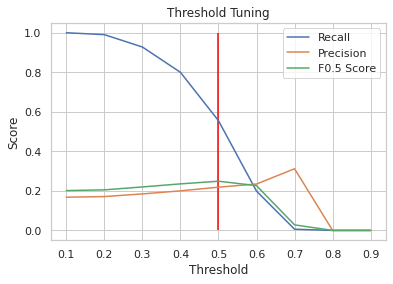

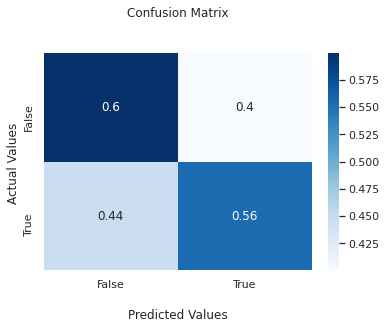

In [0]:
##### CODE CHUNK 9: LR BASELINE CODE AND OUTPUT #####
#### FULL CODE HERE: 
df = baseline_model_2015_df.select('DEP_DEL15', 'ALL_FEATURES_VA')
df = df.na.drop()

# Logistic Regression
MAX_ITER = [5]
ALPHA = [0.0]
LAMBDA = [0.0]
THRESHOLD = [0.5]

param_list = [MAX_ITER, ALPHA, LAMBDA, THRESHOLD]
names = ['MAX_ITER', 'ALPHA', 'LAMBDA', 'THRESHOLD']

gridsearch(full_data = df
           ,k_folds = 1
           ,param_list = param_list
           ,param_names = names
           ,random_shuffle_top_N = 5
           ,model_type = 'lr'
           ,threshold_plot = True
           ,confusion_matrix = True
           ,feature_rank = False)

Looping through param:[('NUM_TREES', 8), ('MAX_DEPTH', 5), ('MAX_BINS', 32)]

0-Fold:

 Train Metrics Validation Metrics

Recall: 0.638 0.584
Precision: 0.591 0.211
Accuracy: 0.599 0.563
F0.5 score: 0.600 0.242
F2 score: 0.628 0.431
F1 score: 0.614 0.310

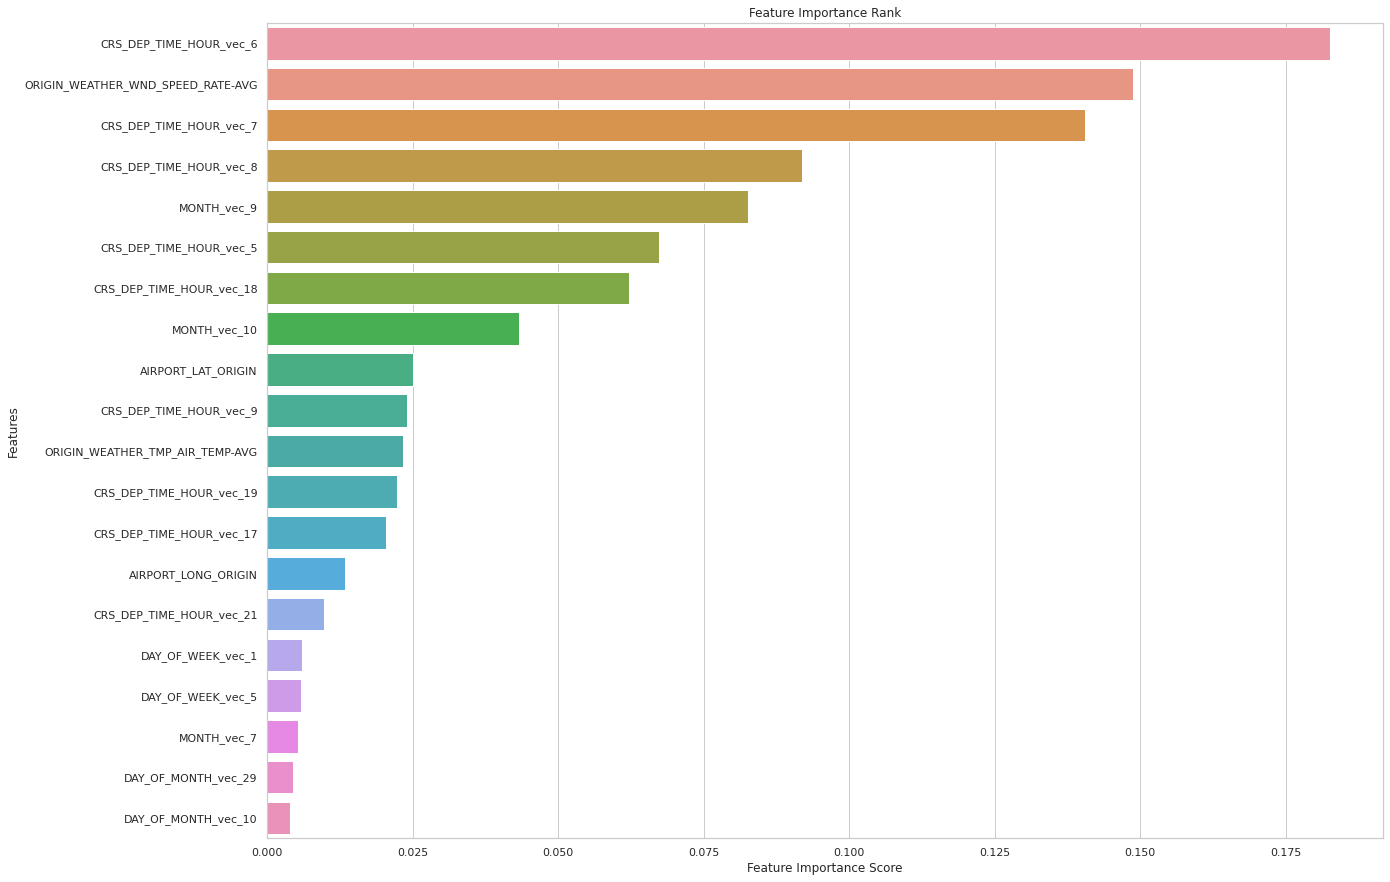

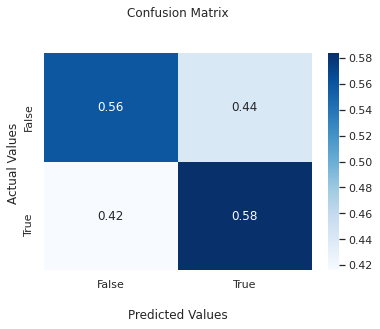

In [0]:
##### CODE CHUNK 10: RF BASELINE CODE AND OUTPUT #####
#### FULL CODE HERE: 
df = baseline_model_2015_df.select('DEP_DEL15', 'ALL_FEATURES_VA')
df = df.na.drop()

# Random Forest
NUM_TREES = [8]
MAX_DEPTH = [5]
MAX_BINS = [32]

param_list = [NUM_TREES, MAX_DEPTH, MAX_BINS]
names = ['NUM_TREES', 'MAX_DEPTH', 'MAX_BINS']

gridsearch(full_data = df
           ,k_folds = 1
           ,param_list = param_list
           ,param_names = names
           ,random_shuffle_top_N = 5
           ,model_type = 'rf'
           ,threshold_plot = False
           ,confusion_matrix = True
           ,feature_rank = True)

Looping through param:[('MAX_ITER', 64), ('ALPHA', 0.2), ('LAMBDA', 0.01), ('THRESHOLD', 0.7)]

0-Fold:

 Train Metrics Validation Metrics

Recall: 0.395 0.400
Precision: 0.855 0.568
Accuracy: 0.664 0.832
F0.5 score: 0.694 0.524
F2 score: 0.443 0.425
F1 score: 0.541 0.470

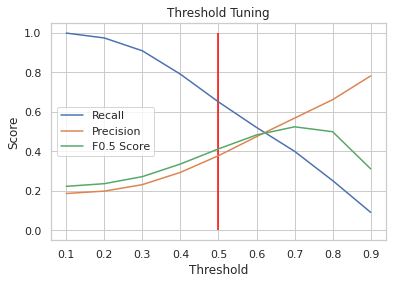

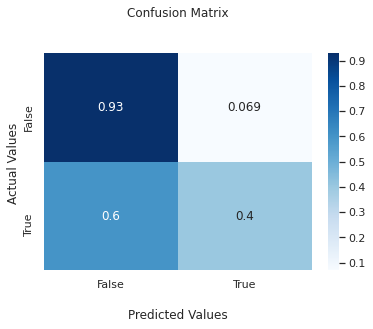

In [0]:
##### CODE CHUNK 11: LR FINAL CODE AND OUTPUT #####
#### FULL CODE HERE:
df = model_transformed_train_2015_18_new_pagerank_noncontscale_df.select('DEP_DEL15', 'ALL_FEATURES_VA')
df = df.na.drop()

blind_test_df = model_transformed_test_2019_new_pagerank_noncontscale_df.select('DEP_DEL15', 'ALL_FEATURES_VA')
blind_test_df = blind_test_df.na.drop()

# Logistic Regression
MAX_ITER = [64]
ALPHA = [0.2]
LAMBDA = [0.01]
THRESHOLD = [0.7]

param_list = [MAX_ITER, ALPHA, LAMBDA, THRESHOLD]
names = ['MAX_ITER', 'ALPHA', 'LAMBDA', 'THRESHOLD']

gridsearch(full_data = df
           ,k_folds = 1
           ,param_list = param_list
           ,param_names = names
           ,random_shuffle_top_N = 5
           ,model_type = 'lr'
           ,threshold_plot = True
           ,confusion_matrix = True
           ,feature_rank = False
           ,blind_test = blind_test_df)

Looping through param:[('NUM_TREES', 128), ('MAX_DEPTH', 10), ('MAX_BINS', 32)]

0-Fold:

 Train Metrics Validation Metrics

Recall: 0.665 0.675
Precision: 0.702 0.335
Accuracy: 0.691 0.691
F0.5 score: 0.694 0.373
F2 score: 0.672 0.561
F1 score: 0.683 0.448

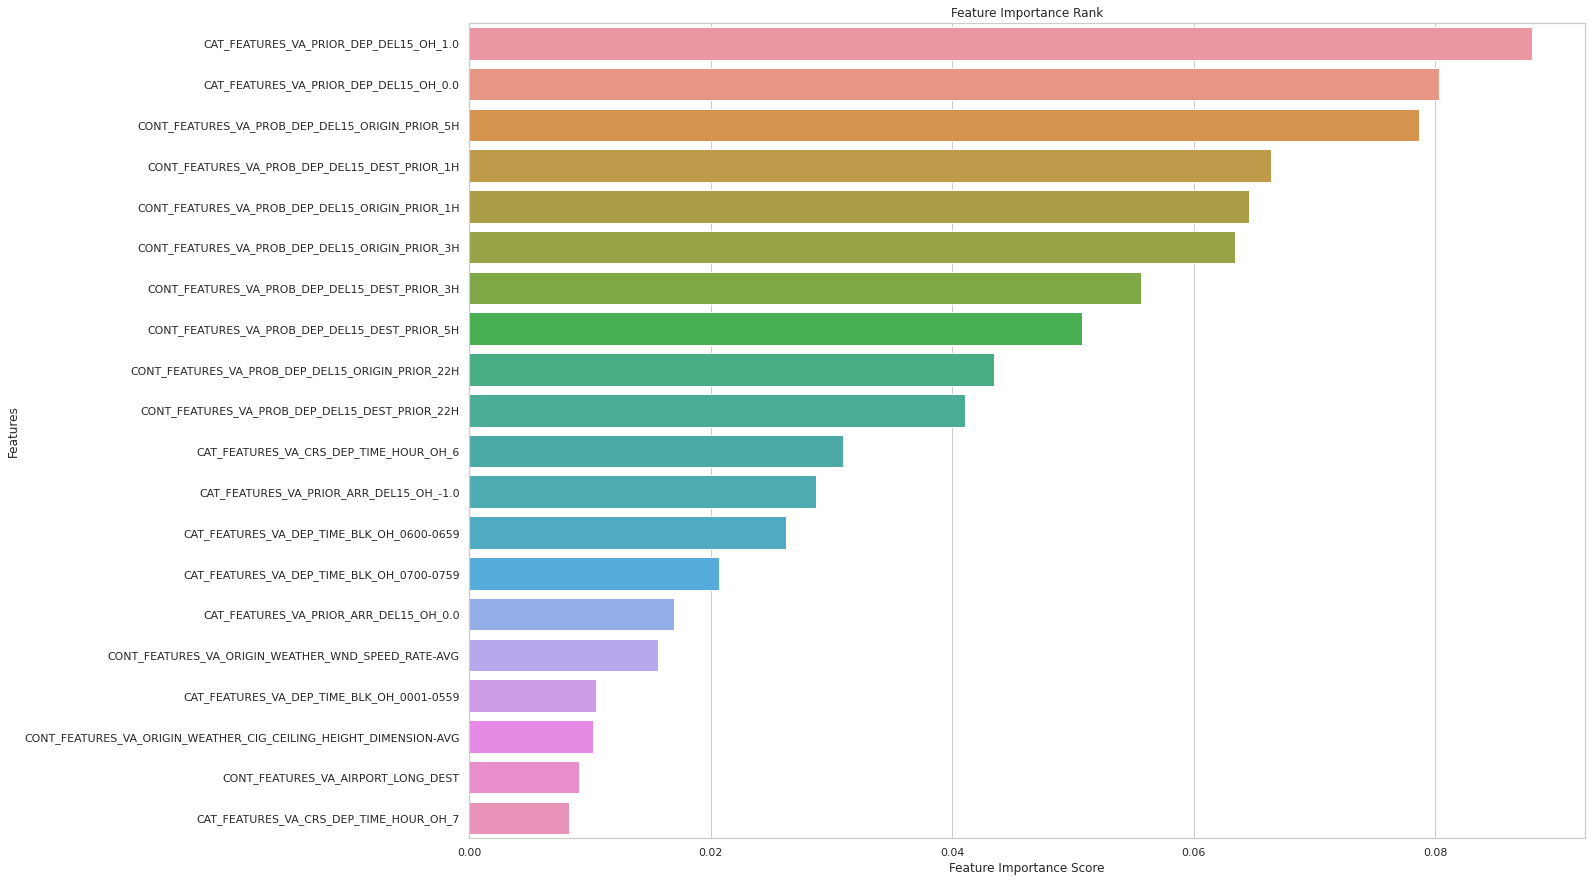

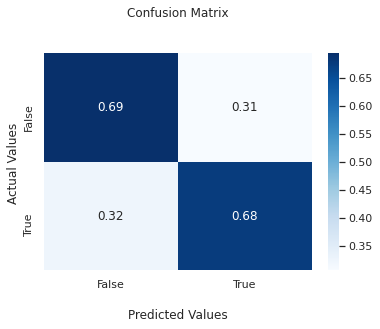

In [0]:
##### CODE CHUNK 12: RF FINAL CODE AND OUTPUT #####
#### FULL CODE HERE:
df = model_transformed_train_2015_18_new_pagerank_noncontscale_df.select('DEP_DEL15', 'ALL_FEATURES_VA')
df = df.na.drop()

blind_test_df = model_transformed_test_2019_new_pagerank_noncontscale_df.select('DEP_DEL15', 'ALL_FEATURES_VA')
blind_test_df = blind_test_df.na.drop()

# Random Forest
NUM_TREES = [128]
MAX_DEPTH = [10]
MAX_BINS = [32]

param_list = [NUM_TREES, MAX_DEPTH, MAX_BINS]
names = ['NUM_TREES', 'MAX_DEPTH', 'MAX_BINS']

gridsearch(full_data = df
           ,k_folds = 1
           ,param_list = param_list
           ,param_names = names
           ,random_shuffle_top_N = 5
           ,model_type = 'rf'
           ,threshold_plot = False
           ,confusion_matrix = True
           ,feature_rank = True
           ,blind_test = blind_test_df)

Looping through param:[('MAX_ITER', 6), ('MAX_DEPTH', 10), ('MAX_BINS', 256), ('STEP_SIZE', 0.2), ('THRESHOLD', 0.77)]

0-Fold:

 Train Metrics Validation Metrics

Recall: 0.382 0.388
Precision: 0.890 0.635
Accuracy: 0.667 0.845
F0.5 score: 0.703 0.563
F2 score: 0.431 0.421
F1 score: 0.535 0.481

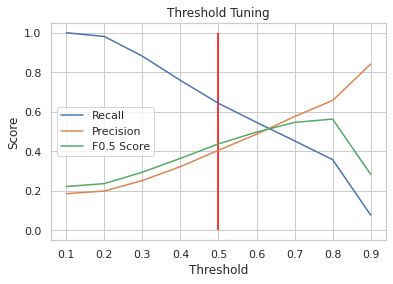

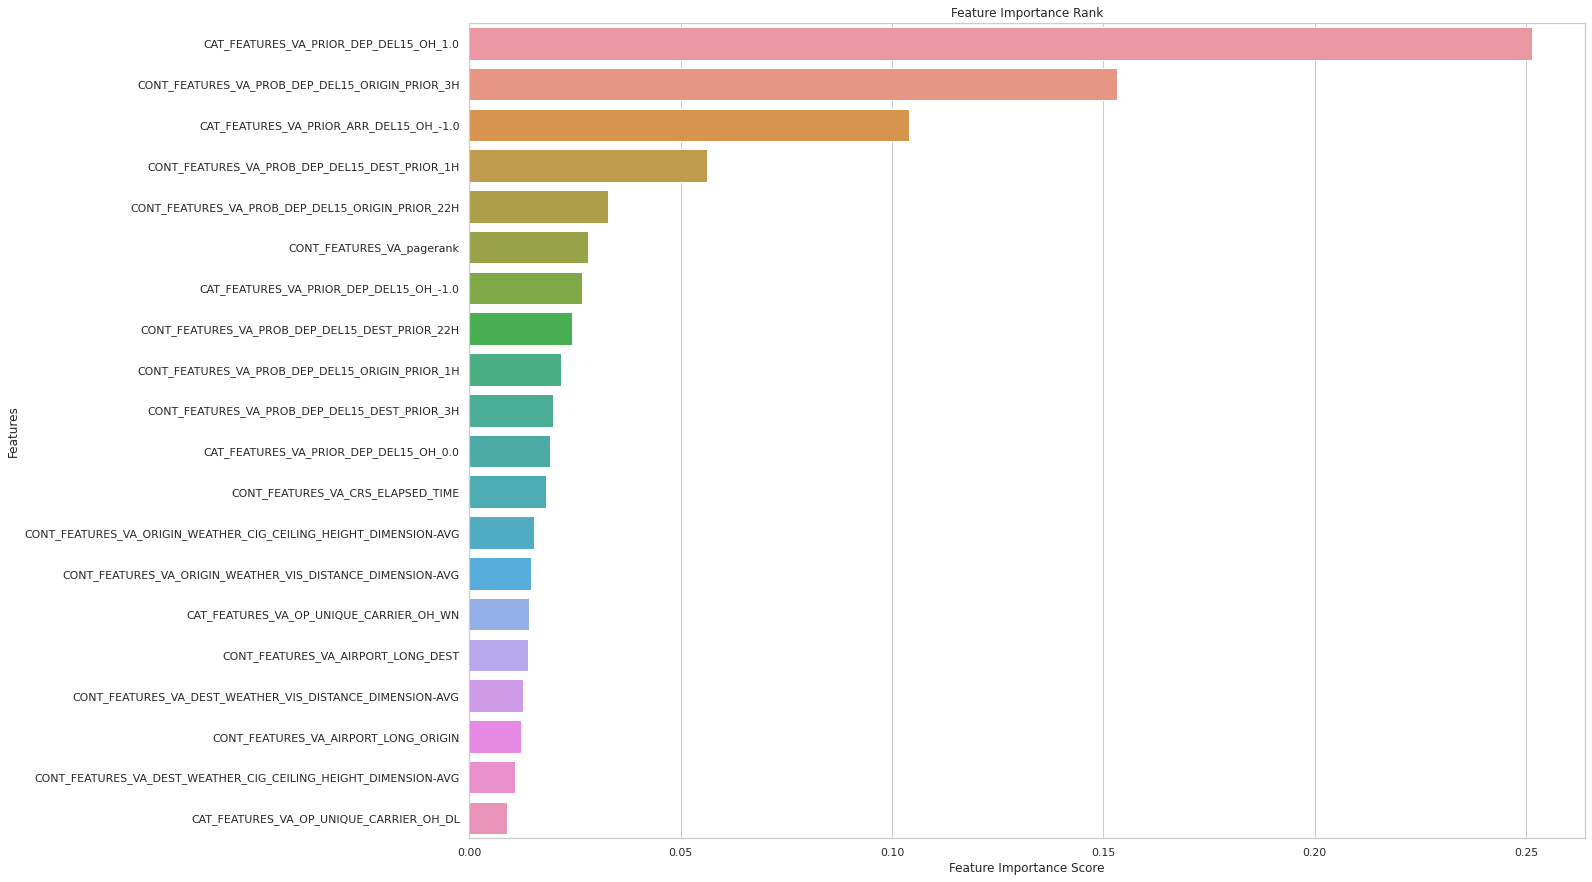

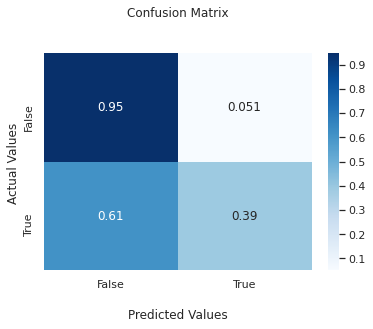

In [0]:
##### CODE CHUNK 13: GBT FINAL CODE AND OUTPUT #####
#### FULL CODE HERE:
df = model_transformed_train_2015_18_new_pagerank_noncontscale_df.select('DEP_DEL15', 'ALL_FEATURES_VA')
df = df.na.drop()

blind_test_df = model_transformed_test_2019_new_pagerank_noncontscale_df.select('DEP_DEL15', 'ALL_FEATURES_VA')
blind_test_df = blind_test_df.na.drop()

# GBT
MAX_ITER = [6]
MAX_DEPTH = [10]
MAX_BINS = [256]
STEP_SIZE = [0.2]
THRESHOLD = [0.77] # delayed class threshold

param_list = [MAX_ITER, MAX_DEPTH, MAX_BINS, STEP_SIZE, THRESHOLD]
names = ['MAX_ITER', 'MAX_DEPTH', 'MAX_BINS', 'STEP_SIZE', 'THRESHOLD']

gridsearch(full_data = df
           ,k_folds = 1
           ,param_list = param_list
           ,param_names = names
           ,random_shuffle_top_N = 5
           ,model_type = 'gbt'
           ,threshold_plot = True
           ,confusion_matrix = True
           ,feature_rank = True
           ,blind_test = blind_test_df)

# V. Algorithm Implementation

> **Prompt:** *Create your own toy example that matches the dataset provided and use this toy example to explain the math behind the algorithm that you will perform. Apply your algorithm to the training dataset and evaluate your results on the test set.*

## Theory

Predicting whether a flight got delayed 2 hours before departure is a classification problem. One of the simplest and widely used models is the logistic regression.  The model depends on whether the relationships in the data meet certain assumptions, which are:

- Linearity: Regression assumes that the input and output variables share a linear relationship. Interaction terms or non-linear terms need to be manually added.

- Normality: The model assumes that the target outcome, given the features follows a normal distribution.

- Homoscedasticity: The model assumes the error around the predicted response has constant variance. However, this error usually is not constant and changes depending on the scenario.

- Independence: The model assumes each datapoint is independent of others. The flight dataset would not meed the independent and identically distributed attribute.

- Fixed features: This assumption implies that the variables are constants and not statistical variables. This assumption is not true realistially. 

- Absence of multicollinearity: Strongly correlated features can lead to problems with weight estimation and can lead to difficulties in determing which of the correlated features attributes to the effects.

The toy example of the logistic regression was implemented using gradient descent. Logistic regression applies the sigmoid function to the typical regression formula. 

$$
  f(x) = \frac{1}{1 + e^{-z}}
$$

The logistic regression used squared loss of log-loss cost function. Below is the LogLoss function: 

$$
  J(\theta) = - \frac{1}{m} \sum_{i=1}^{m} \left[ y^{(i)} \times log(h_{\theta}(x^{(i)})) + (1-y^{(i)}) \times log(h_{\theta}(x^{(i)})) \right]
$$

## Design
> Design choices are explicitly discussed - text and code comments

We decided to only use one year (2019) of data due to resource limitations. For the 80/20 split, the 80% would be months from January to June and 20% would be July and August. The reason we didn't choose January to August for the 80% is to avoid the fall and winter seasons, which the winter weather can be more unpredictable, especially for east coast. There are also more holidays during November and December months. 

We chose logistic regression with sigmoid and threshold of 0.5 as default. The dependent variable is `DEP_DEL15` and since the objective is more on the algorithm implmentation, we thought selecting `pagerank` and `PRIOR_DEP_DEL15` features will be sufficient. 

The flow of our custom logistic regression is as follows: 
1. Load Data, split to train and test roughly 80/20
2. Randomly initialize our first set of weights - it does not necessarily matter where we start
3. Start our Gradient descent - which determines the optimal betas for our model
    
    a. Move along the log-loss function with taking steps gradient descent 
    b. With each iteration of GD, we are moving toward our optimal point that minimizes overall log loss
    c. The log-loss function is convex, so we are gauranteed convergence at some point
    d. Our implementation is fairly basic, and does not have tuned values for step size or any regularization

4. Sigmoid is used to 'squash' output - meaning the output of our model is naturally a probability, which is converted to a binary 'delayed' or 'not delayed' using the sigmoid function
5. Draw predictions from the model, and score with our metrics of interest

## Implementation

The following is the code for implementing logistic regression using a subset of data from our team's final joined dataset. We referenced the sample code provided by from w261 [HelpfulResources directory](https://github.com/UCB-w261/main/blob/main/HelpfulResources/logistic_regression/Logistic%20regression.ipynb). For generating the model results, we are using the MulticlassMetrics library. Please refer to `toy_example_custom_model` notebook for additional details.

As described in the design section, we have functionally programmed each of the above steps. This allows for quick changes to our framework for changes such as a new loss function, etc.

In [0]:
# select label and features
df = model_transformed_test_2019_new_pagerank_noncontscale_df.select(col("MONTH"),  col("DEP_DEL15"), col("pagerank"), col("PRIOR_DEP_DEL15"))

# criteria for the 80/20 split
list_80 = ['1', '2', '3', '4', '5', '6']
list_20 = ['7', '8']
train_df = df.where(col('MONTH').isin(list_80)).drop("MONTH") #1-6
test_df = df.where(col('MONTH') .isin(list_20)).drop("MONTH") #7-8

train_rdd = train_df.rdd
test_rdd = test_df.rdd

# this function converts each RDD rows into dataset used for model
def parse(row):
    """
    Map record_string --> (tuple,of,fields)
    """
    return((row[1], row[2]), row[0])

train_rdd = train_rdd.map(parse).cache()
test_rdd = test_rdd.map(parse).cache()

In [0]:
# sigmoid function
import math
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

In [0]:
# LogLoss function
def LogLoss(dataRDD, W): 
    """
    Compute logistic loss error.
    Args:
        dataRDD - each record is a tuple of (features_array, y)
        W       - (array) model coefficients with bias at index 0
    """
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    ################## YOUR CODE HERE ##################
    loss = augmentedData.map(lambda x: x[1]*np.log(sigmoid(W.dot(x[0]))) + (1-x[1])*np.log(1 - sigmoid(W.dot(x[0])))).mean()*-1
   
    ################## (END) YOUR CODE ##################
    return loss

In [0]:
# gradient descent update
def GDUpdate(dataRDD, W, learningRate = 0.1):
    """
    Perform one gradient descent step/update 
    Args:
        dataRDD - tuple of (features_array, y)
        W       - (array) model coefficients with bias at index 0
        learningRate - (float) defaults to 0.1
        regParam - (float) regularization term coefficient
    Returns:
        model   - (array) updated coefficients, bias still at index 0
    """
    # augmented data
    N=dataRDD.count()
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    
    new_model = None
    #################### YOUR CODE HERE ###################
    # Use the same way as before to find the first component of the gradient function
    # Note: the official equation should be a sum() which provides a lower log loss and a more accurate prediction.
    # However, Spark ML uses mean() for their calculation, possibly to avoid overflow issues.
        
    # Broadcast coeeficients
    sc.broadcast(W)  
    
    grad = augmentedData.map(lambda x: ((sigmoid(W.dot(x[0])) - x[1])*x[0])).sum()
    new_model = W - learningRate * grad/N
    ################## (END) YOUR CODE ####################
    return new_model

In [0]:
# gradient descent function
def GradientDescent(trainRDD, testRDD, wInit, nSteps = 10, learningRate = 0.1, verbose = False):
    """
    Perform nSteps iterations of regularized gradient descent and 
    track loss on a test and train set. Return lists of
    test/train loss and the models themselves.
    """
    # initialize lists to track model performance
    train_history, test_history, model_history = [], [], []
    
    # perform n updates & compute test and train loss after each
    model = wInit
    for idx in range(nSteps):  
        # update the model
        model = GDUpdate(trainRDD, model, learningRate)
        
        # keep track of test/train loss for plotting
        train_history.append(LogLoss(trainRDD, model))
        test_history.append(LogLoss(testRDD, model))
        model_history.append(model)
        
        # console output if desired
        if verbose:
            print("----------")
            print(f"STEP: {idx+1}")
            print(f"Model: {[round(w,3) for w in model]}")
    return train_history, test_history, model_history

In [0]:
# initialize and run the model
wInit = np.random.uniform(0, 1, 3)
results = GradientDescent(train_rdd, test_rdd, wInit, nSteps = 100 )

In [0]:
# get prediction from the model
def getPrediction(testRDD, model): 
    augmentedData = testRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    
    predictions = augmentedData.map(lambda x: (float(sigmoid(model.dot(x[0]))), 1.0 if sigmoid(model.dot(x[0])) > .5 else 0.0, x[1]))
    
    return predictions

In [0]:
# display results
pred_result = getPrediction(test_rdd, results[2][9])
result = pred_result.map(lambda x: (x[1],x[2]))
metrics = MulticlassMetrics(result)
f05 = 1.25 * ((metrics.precision(1.0) * metrics.recall(1.0)) / ((0.25 * metrics.precision(1.0)) + metrics.recall(1.0)))
print(f"accuracy: {metrics.accuracy}")
print(f"Precision: {metrics.precision(1.0)}")
print(f"Recall: {metrics.recall(1.0)}")
print(f"FScore: {metrics.fMeasure(1.0, 0.5)}")
print(f"F0.5: {f05}")

conf_matrix = metrics.confusionMatrix().toArray()
print(f'TP: {conf_matrix[1][1]:.0f}')
print(f'FN: {conf_matrix[1][0]:.0f}')
print(f'TN: {conf_matrix[0][0]:.0f}')
print(f'FP: {conf_matrix[0][1]:.0f}')
print(f"Total Count: {conf_matrix[0][0] + conf_matrix[1][1] + conf_matrix[0][1] + conf_matrix[1][0]:.0f}")

accuracy: 0.7829990023753342
Precision: 0.44221609617888047
Recall: 0.22057767524292612
FScore: 0.36821828995827427
F0.5: 0.36821828995827427
TP: 57749
FN: 204059
TN: 941382
FP: 72841
Total Count: 1276031

## Results
> Clearly presented, clearly discussed

We chose the logistic regression using gradient descent as our algorithm and used 80/20 split. Therefore, the model was trained on 3,428,503 train records and tested on 1,276,031 hold-out samples. 

The result is based on **threshold of 0.5**.

Confusion Matrix:

TP = 57,749

FN = 204,059

TN = 941,382

FP = 72,841

Total Records: 1,276,031

Additional model results:

**Accuracy = 0.78**

**Precision = 0.44**

**Recall = 0.22**

**F0.5 score = 0.37**

This example gave us exposure to creating a custom algorithm that could be run at scale in the absence of specialized packages such as MLLib. In this implementation, we are inherently using tenants from our mapreduce framework, as we start to calculate and carry the loss across x # of mappers, before our weights are determined in a reduce stage by aggregating all mapper outputs.

# VI. Conclusions

> **Prompt:** *report results and learnings for both the ML as well as the scalability.*

#### Machine Learning

Our approach to modeling was quite iterative, as shown from the table in figure 11. Throughout our approach, we continued to train and evaluate three separate frameworks: Logistic Regression, Random Forest, and Gradient Boosted Trees.

Our final and best model was a gradient boosted tree implementation using hyperparameters found over gridsearch. This final model included over 12 different engineered features, methods for dealing with null data, undersampling, and other issues we encountered. While an F0.5 score of .563 is nowhere near cutting edge models, we have more than doubled our initial models, and have improved by nearly 10% compared to Phase III modeling. 

Figure 11 provides a walk of many of our modeling iterations, but is not exhaustive. During our iterations, we implemented a number of techniques that we felt were most impactful, which are highlighted in bold blue. 

Phase II baseline models were fairly simple, and included hyperparameters that were generally set to default values. With stock features and minimal tuning, our best models produced F0.5 scores in the mid 20%s. 

As we moved into Phase III, we first started by including engineered features. These features focused on time-lagged components, and focused on whether the prior leg of the flight was delayed. Over models 4 and 5, these provided great power to our model – raising our scores by up to 13%. An additional feature focusing on airport stress was added in model 7 in conjunction with CV, which raised our F0.5 to .479. At this point, we started our first wide-scale grid searches across our sliding window cross-validation. This exploration set the stage for phase IV, where gridsearch was further expanded. 

In iteration IV, we focused on hyperparameter tuning, and added a few additional features in attempt to increase model performance. One of our most impactful changes to our model was including threshold as a hyperparameter. Plotting across different threshold values provided a curve that allowed us to pick a threshold more optimal for our problem compared to the default logistic and GBT settings of .5. This change along added another incremental /~10% to both LR (10a) and GBT (10b). While addressing changing thresholds, we also included our **novel feature – PageRank** as well as a new weather feature inspired by a conversation with an industry expert. 

#### Scalability and Pipeline Performance

Including Join, training, and inference, our quickest model (logistic regression) can run end to end in less than 20 minutes, with our longest model (GBT) running just over an hour. Each of these infrastructures provide solutions that could feasibly run at current scale, or even with larger sets of data. We believe these two solutions provide users with a reasonable tradeoff between model prediction performance and time required to run. If an organization is intersted in prediction ability and able to accept longer run-times, we would suggest usage of our GBT algorithm. This model provides users with our highest yet F0.5, while running in about an hours time. If an organization needs to scale upward, however, and add in even more data, we might suggest logistic regression. This model performed similarly to GBT (roughly 4% less) but takes one fourth of the time, making it a much more scalable solution. Overall, both solutions have the ability to scale depending on an organizations need for timely output.

**Figure 12: Table of Model Iteration Results**

![fig12](https://raw.githubusercontent.com/ruby-han/W261/main/images/fig12.png)

## Interpretation 
> interpret and visualize - i.e. confusion matrix

Returning to our initial problem statement, we worked to provide a flight delay prediction algorithm specifically tailored for airline stakeholders. Because of this, we wanted to reduce the frequency of false positives (yellow sector) while also providing users with high prediction ability. This influenced our metric of choice – causing us to favor precision in a balanced manner, therefore choosing F0.5. 

Each of our models was ultimately scored using F0.5, and Logistic Regression and GBT ended in the same range. Referencing the Random Forest confusion matrix in Figure 12, it is evident that this algorithm was least successful in minimizing false positives. While our random forest approach yielded the highest pure accuracy, we saw high amounts of false positives, and lower success in properly classifying an on-time flight as on-time. This did not meet our goal set, and is ultimately the reason we are not accepting this random forest implementation as one of our final production models. 

Logistic regression and Gradient boosted trees performed similarly in their final implementation, with each sector of the confusion matrix being small percentage points off. Each of these models met our goal of minimizing false positives (/~5%), and ended with F0.5 scores in the mid 50%s. From our confusion matrix, we can see that one of the ways we’re minimizing false positives is by heavily weighting predictions toward the majority class. Even when a flight is delayed (Actual = 1), 60% of the time we’re incorrectly classifying it as an on-time flight. 

This tradeoff can only be taken so far with hyperparameter tuning and model selection. We believe that we have selected the optimal hyperparameters, and that in order to increase our True Positive prediction, we will need provide the model with additional information that helps it clearly identify a flight that is at high risk of delay. Despite our 12 engineered features and many transformations, we still have work to do in providing the model with the best information possible. Further discussion of possible future work is found in Appendix B – Gap Analysis.

**Figure 13: Final Confusion Matrices**

![fig13](https://raw.githubusercontent.com/ruby-han/W261/main/images/fig13.png)

## So what?
> Draw effective conclusions that justify original problem statement actually solved

While our models did not surpass our ideal benchmark of 70%, we have created a tool that airline stakeholders can use to add to their gut-instinct delay prediction heuristic. We believe that with an F0.5 above 55%, airlines can have a more systematic prediction framework that can help inform whether or not they should take action to deal with or announce a future delay. As mentioned in our business relevance, it was important that our model would not signal action in the case of a false positive, or when a flight will not actually be delayed. We believe that when using our solution that stakeholders can act with confidence that our model will rarely lead them to announce a flight is delayed when it will not actually be delayed. 

While we have future work to do to make this a truly state-of-the-art solution, we believe we can continue to make incremental improvement, while protecting airline stakeholders against false positives.

# VII. Application of Course Concepts

> **Prompt:** *Pick 3-5 key course concepts and discuss how your work on this assignment illustrates an understanding of these concepts.*

> 1/2 page, ~3 paragraphs. Demonstrates understanding of chosen concepts, addresses how algorithm performance/scalability/practicality would have been different given a different application

## Concept 1: Functional and Object Oriented Programming 

Functional programming paradigm can be described as the process of writing pure functions, avoiding shared states, mutable data and side effects. This becomes paramount when working in a distributed system environment such as Apache Spark. As we started our exploratory data analysis for the project, we quickly realized that each group member was replecating code and coming across similar *how to* problems. To operate more seamlessly and in an efficient manner, we added a layer of abstraction for splitting data (train/test) and training models. Next, we further built the classes to have functions to plot various metrics and describe key performance indicators. 

The end to end pipeline harnessed this capability by using a wrapper around the `Model` class which takes in the `dataset`, `model`, `hyper-parameters` and `metrics` as inputs and outputs a summary of the model.  Once this pipeline was available, running gridsearch or testing new models for each team member was as simple as writing one line of code. This helped the group scale up and improved our performance, focusing on the end goal of predicting flight delays instead of using our time to plumb each and every step of the pipeline.

## Concept 2: Bias-Variance Trade-off
The bias-variance trade-off is relevant for supervised machine learning model selection process. It is a method to diagnose model performance by distilling down its prediction error. High bias and low variance algorithms train models that are consistent but inaccurate on average (underfit). Logistic regression model is an example of low variance algorithm which tends to be less complex but with rigidity in its underlying structure. High variance and low bias algorithms train models that are inconsistent but accurate on average (overfit, noisy and unable to generalize well). Decision tree model is an example of low bias algorithm which tends to be more complex but with flexibility in its underlying structure. Hence, it is important to minimize total error to determine optimal model complexity. Our models showed tendencies to overfit as trained metrics were better than validation metrics. This indicated that our models do not generalize well on the test set. Various measures were adopted to reduce model complexity - hyperparameter tuning, undersampling majority class, regularization, cross-validation, random grid search and reducing tree depth as well as step sizes for tree models.

## Concept 3: Caching, DAGs, and Lazy Evaluation

Our understanding of caching, DAGs, and Lazy Evaluation was challenged through early and mid portions of join infrastructure setup. We conceptually understood that lazy evaluation meant the machine would not be executing DAG instructions unless an action or result was required by the user, but were unsuccessful in applying this initially. Our first join iterations were filled with `.cache()` between different steps of the join steps, but when we ran the join sequence, we still observed very high run times on small datasets. Following these earlier failures, we spent time researching how to properly implement caching and checkpointing to best optimize our process flow within a framework reliant on DAGs and Lazy evaluation. 

At each step when we are writing code, we are only creating a set of instructions for the machine to run on later - or a DAG. Even when we run these code chunks, we’re only asking the interpreter to check for syntax, it’s not *actually* executing these parts of the DAG. When a result is actually *required*, these set of instructions will execute with the purpose of reflecting that result back. Without caching or checkpointing, identical runs of that same set of instructions will take the same amount of time - and be quite long. Even when we included cache steps between jobs, without evaluation being forced, these intermediate dataframes were never committed to the cache. 

With this concept of lazy evaluation and DAG generation in mind, we changed our workflow to the following:
1. Develop/run code for a time-intensive portion of the join process
2. Include code chunk with `.cache()` directly after this step to ensure next time a result is collected, the dataframe will be cached
3. Collect a result for the intermediate step in the dataframe, like `.count()`
4. [Optional] checkpoint intermediate data to blob, pull back into notebook
5. Repeat steps 1-3 on following sub-tasks in a join

Without caching and checkpointing, every time we ran our operations the entire set of DAG instructions would be executed, even if we had already ran them once before. This made early development of joins extremely slow. 

This updated process provided great returns to our heaviest operations. While it included some ‘start-up’ cost in terms of caching at intermediate steps, it allowed us to develop and iterate through computationally/time-intensive processes much quicker, and resulted in fast final joins.

# Appendix

## Appendix A: Phase Summaries

### Phase I
Our initial EDA tasks were focused on understanding the data and features, exploring null values, and determining metrics for evaluation of our future model. Early in the process we were able to identify that our data is heavily imbalanced - with only 20% of our data classified as a flight delay. Second, we narrowed down the list of features based on proportion of null values. We dropped roughly half of the features in our `airlines` dataset, and 90% of the features in `weather`.

We also focused on how we would augment our flight data to increase forecast performance. To do this, include two different auxiliary tables - `stations` which is provided, and an airport to lat/long mapping, pulled from the web. A series of three joins described below will be necessary to create our full dataset. 

Finally, we decided that the metric best suited to help airlines reduce costs would be precision. This metric directly measures the share of false positives in relation to total positives, and gives us a mechanism to measure how often we incorrectly predict a delay when a delay does not actually occur. We believe these false positives to be the most costly mistakes. (*~972 chars not including spaces*)

### Phase II

Our EDA continuation was heavily focused on understanding null values and treating them. Following removal of features with 70% or greater null values, we treated missing data by applying a 7-day look-back window. In addition to imputation of null values, we ran a number of transformations like time-stamp conversions, lags, etc in preparation for joining of weather data to airline data. These treatments allowed a reducton of null-values from ~30%, to less than 2.5%. 

Following Null value treatment and other pipeline transformations, we left joined weather to airlines, using stations as a mapper. Instead of a custom distance metric using lat/long, we mapped the shortest ICAO-to-station_ID, and pulled weather for these stations. 

Finally, we assembled a baseline model using logistic regression, and the 26 categorical and continuous variables we believed held the highest predictive power. Without full treatment of class imbalance, our model was unable to predict well, and produed precision scores in the 20%s. Next stages will focus on feature engineering, over-/under-sampling, sliding window CV, and other techniques to increase model power.  

Phase II updates included in **EDA & Discussion of Challenges** in addition to Phase I, and **Feature Engineering and Transformations**

### Phase III

The first portion of this phase focused on implementing our join infrastructure from phase II to the full dataset. Our join took roughly 5 minutes with the help of caching, treatment of data before joining, and reature reductino. 

The second portion of this phase was focused on building a cross-validation and gridsearch framework that would allow for iteration over our master data set, in order to search for best combinations of hyperparameters. 

In parallel, other group members focused on creating three new features related to Airport stress, centrality, and prior flight delays. 

Finally, we iterated over many combinations of features, train/test sizes, and hyperparameters to reach a phase III F0.5 score of .47.

### Phase IV

Our final phase of the projecct was focused on hyperparameter tuning, adding in a few additional features, and report writing. 

By this point, our modeling framework was already established, and allowed us to quickly iterate through different hyperparameter tunings and models. Additionally, one of our biggest impact changes was changing the threshold on LR and GBT models. 

The majority of our time was spent on final report writing.

## Appendix B: Final Gap Analysis

At the time of writing (3:49p PT 4/10), our F0.5 performance relative to other groups scoring F0.5 put us at the high-middle of the pack, in the high .50s. Three other groups outperformed us with scores upwards of 70%. Following all of our hyperparameter tuning via gridsearch in Phase IV, we believe we have at this point met the reasonable limits of our deployed algorithms, and would not find substantial gains from additional hyperparameter tuning. Of course, since we were not able to test every combination of hyperparameters we have missed many, but we believe our primary issue is not providing *good enough* data for our model to effectively separate out future delay from future on-time flights. This is an information availability problem. 

We believe with additional resources, we could improve our model by tackling three main issues:

1. Expanded domain knowledge
    
    a. Instead of choosing features we think are best, we'd like to have a better understanding of the domain to make better choices on what features to incude, and what features to engineer

2. Algorithmic feature selection techniques

    a. While we believe we may not be providing the model with the best information, that does not mean we're not providing it with *enough* information
    b. In fact, we could be over-saturating our model
    c. Automated feature selection techniques like Principle Component Analysis could aide in selecting only the best features, giving our model the *most useful* information rather than all of the information
    
3. Additional EDA to better inform transformations

    a. Within the timeline of our project, we simply did not have enough time to do all of the EDA that would be necessary to create the best imputation/transformation strategy
    b. Our null value imputation strategy was wide-ranging, and included a 7-day lookback. 
    c. It's reasonable to assume that across different measures, different distributions and patterns underly the data which would suggest different imputation would be better
    
In summary, we believe that we implemented many of the techniques that we've learned throughout the course of our time in MIDS. However, we have no doubt that these techniques could be fine-tuned further. 

Our full join pipeline performed toward the top of all groups at less than 10 minutes, which we attribute to heavy use of caching as well as purposefull cleaning/feature reduction before join.

## Appendix C: References and Notebook Links

### References

[1] https://www.faa.gov/data_research/aviation_data_statistics/media/cost_delay_estimates.pdf

[2] https://journalofbigdata.springeropen.com/articles/10.1186/s40537-020-00380-z

[3] Airlines reference

[4] Weather reference

[5] Stations reference

[6] https://machinelearningmastery.com/fbeta-measure-for-machine-learning/

[7] https://www.investopedia.com/terms/m/multicollinearity.asp

[8] https://towardsdatascience.com/csv-files-for-storage-no-thanks-theres-a-better-option-72c78a414d1d

[9] https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html

[10] Week 10 Async and In-class material

[11] [Logistic Regression: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/logistic.html)

[12] [Random Forest](https://spark.apache.org/docs/latest/mllib-decision-tree.html)

[13] [Gradient Boosted Trees](https://spark.apache.org/docs/latest/mllib-ensembles.html#gradient-boosted-trees-gbts)

### Notebooks

[A] [EDA](https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#folder/1898361324233394)

[B] [Imports](https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/3816960191357546/command/3816960191357547)

[C] [Data Processing & Ingestion](https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#folder/2866290024316334)

[D] [Feature Selection](https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/3624340554639285/command/3624340554639286)

[E] [Joins](https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/1343325974184049/command/1343325974184051)

[F] [Modeling](https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/1898361324259458/command/1898361324259459)

## Appendix D: Feature List

In [0]:
AIRLINE_FEATURES = [
 'YEAR',
 'QUARTER',
 'MONTH',
 'DAY_OF_MONTH',
 'DAY_OF_WEEK',
 'FL_DATE',
    
 'OP_UNIQUE_CARRIER',
 'OP_CARRIER_AIRLINE_ID',
#  'OP_CARRIER',
 'TAIL_NUM',
 'OP_CARRIER_FL_NUM',
    
 'ORIGIN_AIRPORT_ID',
 'ORIGIN_AIRPORT_SEQ_ID',
#  'ORIGIN_CITY_MARKET_ID',
 'ORIGIN',
 'ORIGIN_CITY_NAME',
 'ORIGIN_STATE_ABR',
#  'ORIGIN_STATE_FIPS',
#  'ORIGIN_STATE_NM',
#  'ORIGIN_WAC',
    
 'DEST_AIRPORT_ID',
 'DEST_AIRPORT_SEQ_ID',
#  'DEST_CITY_MARKET_ID',
 'DEST',
 'DEST_CITY_NAME',
 'DEST_STATE_ABR',
#  'DEST_STATE_FIPS',
#  'DEST_STATE_NM',
#  'DEST_WAC',
    
 'CRS_DEP_TIME',
 'DEP_TIME',
 'DEP_DELAY',
 'DEP_DELAY_NEW',
 'DEP_DEL15',
 'DEP_DELAY_GROUP',
 'DEP_TIME_BLK',
    
 'TAXI_OUT',
 'WHEELS_OFF',
 'WHEELS_ON',
 'TAXI_IN',
    
 'CRS_ARR_TIME',
 'ARR_TIME',
 'ARR_DELAY',
 'ARR_DELAY_NEW',
 'ARR_DEL15',
 'ARR_DELAY_GROUP',
 'ARR_TIME_BLK',
    
 'CANCELLED',
#  'CANCELLATION_CODE',
 'DIVERTED',
    
 'CRS_ELAPSED_TIME',
 'ACTUAL_ELAPSED_TIME',
 'AIR_TIME',
 'FLIGHTS',
 'DISTANCE',
 'DISTANCE_GROUP',
    
 'CARRIER_DELAY',
 'WEATHER_DELAY',
 'NAS_DELAY',
 'SECURITY_DELAY',
 'LATE_AIRCRAFT_DELAY',
    
#  'FIRST_DEP_TIME',
#  'TOTAL_ADD_GTIME',
#  'LONGEST_ADD_GTIME',
    
#  'DIV_AIRPORT_LANDINGS',
#  'DIV_REACHED_DEST',
#  'DIV_ACTUAL_ELAPSED_TIME',
#  'DIV_ARR_DELAY',
#  'DIV_DISTANCE',
#  'DIV1_AIRPORT',
#  'DIV1_AIRPORT_ID',
#  'DIV1_AIRPORT_SEQ_ID',
#  'DIV1_WHEELS_ON',
#  'DIV1_TOTAL_GTIME',
#  'DIV1_LONGEST_GTIME',
#  'DIV1_WHEELS_OFF',
#  'DIV1_TAIL_NUM',
#  'DIV2_AIRPORT',
#  'DIV2_AIRPORT_ID',
#  'DIV2_AIRPORT_SEQ_ID',
#  'DIV2_WHEELS_ON',
#  'DIV2_TOTAL_GTIME',
#  'DIV2_LONGEST_GTIME',
#  'DIV2_WHEELS_OFF',
#  'DIV2_TAIL_NUM',
#  'DIV3_AIRPORT',
#  'DIV3_AIRPORT_ID',
#  'DIV3_AIRPORT_SEQ_ID',
#  'DIV3_WHEELS_ON',
#  'DIV3_TOTAL_GTIME',
#  'DIV3_LONGEST_GTIME',
#  'DIV3_WHEELS_OFF',
#  'DIV3_TAIL_NUM',
#  'DIV4_AIRPORT',
#  'DIV4_AIRPORT_ID',
#  'DIV4_AIRPORT_SEQ_ID',
#  'DIV4_WHEELS_ON',
#  'DIV4_TOTAL_GTIME',
#  'DIV4_LONGEST_GTIME',
#  'DIV4_WHEELS_OFF',
#  'DIV4_TAIL_NUM',
#  'DIV5_AIRPORT',
#  'DIV5_AIRPORT_ID',
#  'DIV5_AIRPORT_SEQ_ID',
#  'DIV5_WHEELS_ON',
#  'DIV5_TOTAL_GTIME',
#  'DIV5_LONGEST_GTIME',
#  'DIV5_WHEELS_OFF',
#  'DIV5_TAIL_NUM'
]


WEATHER_FEATURES = [
'STATION',
'DATE',
# 'SOURCE',
'LATITUDE',
'LONGITUDE',
'ELEVATION',
'NAME',
# 'REPORT_TYPE',
# 'CALL_SIGN',
# 'QUALITY_CONTROL',
'WND',
'CIG',
'VIS',
'TMP',
'DEW',
'SLP',
# 'AW1',
# 'GA1',
# 'GA2',
# 'GA3',
# 'GA4',
# 'GE1',
# 'GF1',
# 'KA1',
# 'KA2',
# 'MA1',
# 'MD1',
# 'MW1',
# 'MW2',
# 'OC1',
# 'OD1',
# 'OD2',
# 'REM',
# 'EQD',
# 'AW2',
# 'AX4',
# 'GD1',
# 'AW5',
# 'GN1',
# 'AJ1',
# 'AW3',
# 'MK1',
# 'KA4',
# 'GG3',
# 'AN1',
# 'RH1',
# 'AU5',
# 'HL1',
# 'OB1',
# 'AT8',
# 'AW7',
# 'AZ1',
# 'CH1',
# 'RH3',
# 'GK1',
# 'IB1',
# 'AX1',
# 'CT1',
# 'AK1',
# 'CN2',
# 'OE1',
# 'MW5',
# 'AO1',
# 'KA3',
# 'AA3',
# 'CR1',
# 'CF2',
# 'KB2',
# 'GM1',
# 'AT5',
# 'AY2',
# 'MW6',
# 'MG1',
# 'AH6',
# 'AU2',
# 'GD2',
# 'AW4',
# 'MF1',
# 'AA1',
# 'AH2',
# 'AH3',
# 'OE3',
# 'AT6',
# 'AL2',
# 'AL3',
# 'AX5',
# 'IB2',
# 'AI3',
# 'CV3',
# 'WA1',
# 'GH1',
# 'KF1',
# 'CU2',
# 'CT3',
# 'SA1',
# 'AU1',
# 'KD2',
# 'AI5',
# 'GO1',
# 'GD3',
# 'CG3',
# 'AI1',
# 'AL1',
# 'AW6',
# 'MW4',
# 'AX6',
# 'CV1',
# 'ME1',
# 'KC2',
# 'CN1',
# 'UA1',
# 'GD5',
# 'UG2',
# 'AT3',
# 'AT4',
# 'GJ1',
# 'MV1',
# 'GA5',
# 'CT2',
# 'CG2',
# 'ED1',
# 'AE1',
# 'CO1',
# 'KE1',
# 'KB1',
# 'AI4',
# 'MW3',
# 'KG2',
# 'AA2',
# 'AX2',
# 'AY1',
# 'RH2',
# 'OE2',
# 'CU3',
# 'MH1',
# 'AM1',
# 'AU4',
# 'GA6',
# 'KG1',
# 'AU3',
# 'AT7',
# 'KD1',
# 'GL1',
# 'IA1',
# 'GG2',
# 'OD3',
# 'UG1',
# 'CB1',
# 'AI6',
# 'CI1',
# 'CV2',
# 'AZ2',
# 'AD1',
# 'AH1',
# 'WD1',
# 'AA4',
# 'KC1',
# 'IA2',
# 'CF3',
# 'AI2',
# 'AT1',
# 'GD4',
# 'AX3',
# 'AH4',
# 'KB3',
# 'CU1',
# 'CN4',
# 'AT2',
# 'CG1',
# 'CF1',
# 'GG1',
# 'MV2',
# 'CW1',
# 'GG4',
# 'AB1',
# 'AH5',
# 'CN3', 
]

# doc: https://docs.databricks.com/notebooks/notebook-workflows.html
features = {'WEATHER': WEATHER_FEATURES, 'AIRLINE': AIRLINE_FEATURES}
dbutils.notebook.exit(features)

{'WEATHER': ['STATION', 'DATE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'NAME', 'WND', 'CIG', 'VIS', 'TMP', 'DEW', 'SLP'], 'AIRLINE': ['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE', 'OP_UNIQUE_CARRIER', 'OP_CARRIER_AIRLINE_ID', 'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'DEST', 'DEST_CITY_NAME', 'DEST_STATE_ABR', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_DELAY_GROUP', 'DEP_TIME_BLK', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'ARR_DELAY_NEW', 'ARR_DEL15', 'ARR_DELAY_GROUP', 'ARR_TIME_BLK', 'CANCELLED', 'DIVERTED', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'FLIGHTS', 'DISTANCE', 'DISTANCE_GROUP', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']}